# Extract Deep Learning Features for NSynth Data

- Regular convolution
- Deformable convolution
- Dilated convolutions
- 1D Frequency
- 1D Time
- Feed forward


Code References:
- Data loading: https://discuss.pytorch.org/t/input-numpy-ndarray-instead-of-images-in-a-cnn/18797/3
- Deformable convolution: https://github.com/4uiiurz1/pytorch-deform-conv-v2
- Extracting deep features in PyTorch: https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6


Train all architectures to extract features based on classification of INSTRUMENT FAMILY

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
sns.set(font_scale = 1.7)
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import time
from sklearn import metrics
from sklearn.linear_model import LinearRegression

In [2]:
## Load data
## Load in data
labels = np.load('../Data/NSynth/accoustic-labels.npz')
inds = np.load('../Data/NSynth/accoustic-train-test-inds.npz')
stft = np.load('../Data/NSynth/accoustic-stft-db.npy')

instrument_family = labels['arr_0']
instrument = labels['arr_1']
pitch = labels['arr_2']
velocity = labels['arr_3']
sound_qualities = labels['arr_4']
source = labels['arr_5']

## train_test split
train_inds = inds['arr_0']
test_inds = inds['arr_1']
train_if = instrument_family[train_inds]
test_if = instrument_family[test_inds]

train_pitch = pitch[train_inds]
test_pitch = pitch[test_inds]

train_velocity = velocity[train_inds]
test_velocity = velocity[test_inds]

train_sq = sound_qualities[train_inds, :]
test_sq = sound_qualities[test_inds, :]


train_stft = stft[train_inds, :, :]
test_stft = stft[test_inds, :, :]

orig_mean = np.mean(train_stft)
orig_std = np.std(train_stft)
### Normalize based on training parameters
test_stft = (test_stft - np.mean(train_stft))/np.std(train_stft)
train_stft = (train_stft - np.mean(train_stft))/np.std(train_stft)


In [3]:
## transform categories
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
test_trans = le.fit_transform(test_if)
train_trans = le.fit_transform(train_if)

In [4]:
# from https://discuss.pytorch.org/t/input-numpy-ndarray-instead-of-images-in-a-cnn/18797/3

class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [5]:
bs = 64

train_set = MyDataset(train_stft, train_trans)
train_loader = DataLoader(train_set, batch_size=bs, shuffle=False)
test_set = MyDataset(test_stft, test_trans)
test_loader = DataLoader(test_set, batch_size=bs, shuffle=False)


In [6]:
def train(model, train_loader, criterion, optimizer, epoch):
    train_loss = 0
    model.train()
    correct = 0
    loss_output = list()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
#         print(data.size(), output.size(), target.size())
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        
    train_loss = train_loss/(batch_idx+1)/len(train_loader.dataset)
    loss_output.append(train_loss)
    acc = 100. * correct / len(train_loader.dataset)
    return(loss_output, acc)

def test(model, test_loader, criterion, epoch, batch_size = 64):
    model.eval()
    test_loss = 0
    correct = 0
    loss_output = list()
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
            target = target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss = (test_loss*batch_size)/len(test_loader.dataset)
    loss_output.append(test_loss)
    acc = 100. * correct / len(test_loader.dataset)
    return(loss_output, acc)

## (1) Compare Number of Channels - Regular Convolutions

In [18]:
class CNN1(nn.Module): #(5, 10, 10) channels
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 5, kernel_size = 5,
                              stride = 1, padding = 0)
        self.conv1_bn1 = nn.BatchNorm2d(5)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(5, 10, kernel_size = 5, stride = 3, padding = 3)
        self.conv2_bn2 = nn.BatchNorm2d(10)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(10, 10, kernel_size = 5, stride = 2, padding = 0)
        self.conv3_bn3 = nn.BatchNorm2d(10)
        self.fc1 = nn.Linear(10 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 8)

    def forward(self, x):
#         print(x.shape)
        x = self.pool1(F.relu(self.conv1_bn1(self.conv1(x))))
#         print(x.shape)
        x = self.pool2(F.relu(self.conv2_bn2(self.conv2(x))))
#         print(x.shape)
        x = F.relu(self.conv3_bn3(self.conv3(x)))
#         print(x.shape)
        x = x.view(-1, 10*4*4)
#         print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

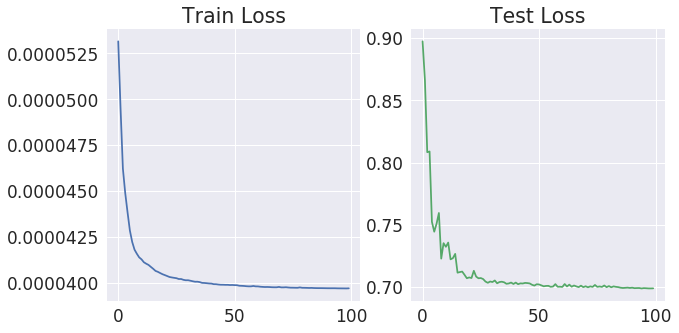

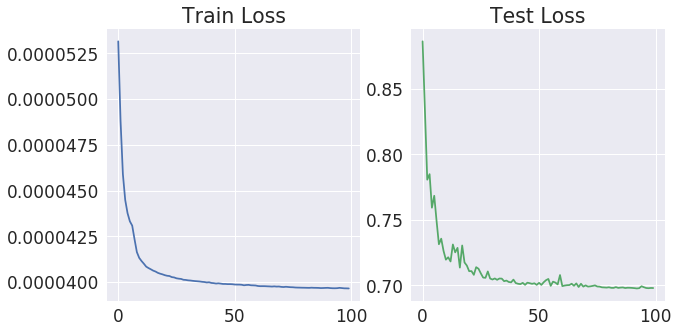

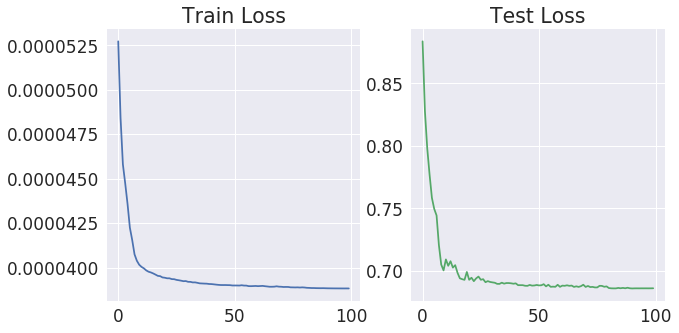

[[88.283 87.947]
 [88.489 88.04 ]
 [91.451 90.527]]
[89.408 88.838] [1.448 1.195]
5494.677863836288
24238


In [19]:
out_channels = 8
lr=0.005
momentum=0.9
num_epochs = 100
start_time = time.time()
## Three random restarts
results = np.zeros((3, 2))
count = 0
for seed in [1,10,17]:
    device = 'cuda'
    torch.manual_seed(seed)
    device = torch.device(device)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    model = CNN1().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum) 

    train_loss = list()
    test_loss = list()
    train_acc = list()
    test_acc = list()
    for epoch in range(1, num_epochs + 1):
        tl, ta = train(model, train_loader, criterion, optimizer, epoch)
        train_loss.append(tl)
        train_acc.append(ta)
        testl, testa = test(model, test_loader, criterion, epoch)
        test_loss.append(testl)
        test_acc.append(testa)

    plt.figure(figsize = (10,5))
    plt.subplot(1,2,1)
    plt.plot(train_loss)
    plt.title('Train Loss')
    plt.subplot(1,2,2)
    plt.plot(test_loss, color = 'C1')
    plt.title('Test Loss')
    plt.show()
    ## Return final train and test accuracy
    results[count, :] = [ta, testa]
    count += 1
print(np.round(results, 3))
print(np.round(np.mean(results, axis = 0), 3), 
      np.round(np.std(results, axis = 0), 3))
end_time = time.time()
print(end_time - start_time)
## Count number of parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

In [20]:
class CNN2(nn.Module): #(10, 10, 10) channels
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 5,
                              stride = 1, padding = 0)
        self.conv1_bn1 = nn.BatchNorm2d(10)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(10, 10, kernel_size = 5, stride = 3, padding = 3)
        self.conv2_bn2 = nn.BatchNorm2d(10)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(10, 10, kernel_size = 5, stride = 2, padding = 0)
        self.conv3_bn3 = nn.BatchNorm2d(10)
        self.fc1 = nn.Linear(10 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 8)

    def forward(self, x):
#         print(x.shape)
        x = self.pool1(F.relu(self.conv1_bn1(self.conv1(x))))
#         print(x.shape)
        x = self.pool2(F.relu(self.conv2_bn2(self.conv2(x))))
#         print(x.shape)
        x = F.relu(self.conv3_bn3(self.conv3(x)))
#         print(x.shape)
        x = x.view(-1, 10*4*4)
#         print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

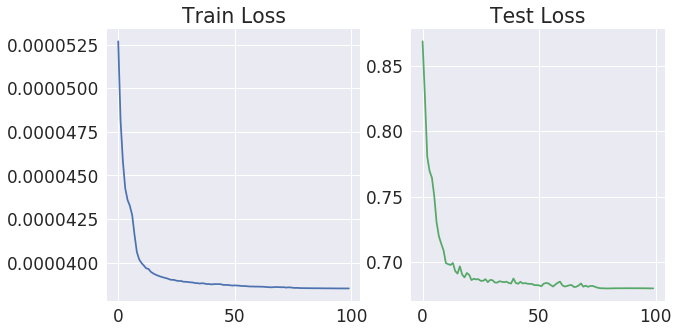

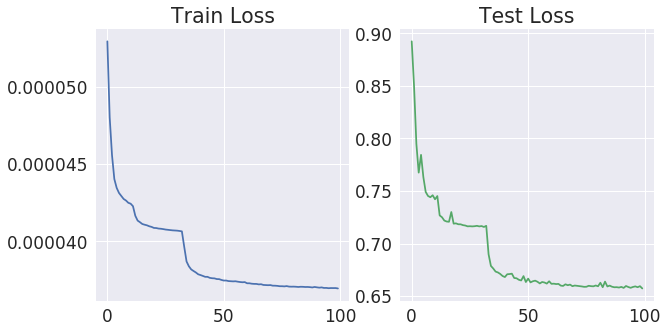

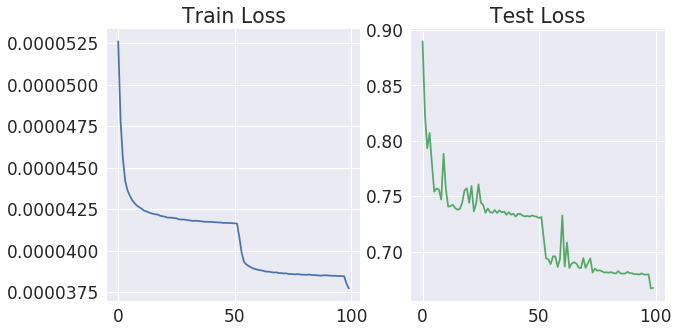

[[92.491 91.713]
 [98.16  96.433]
 [95.723 94.7  ]]
[95.458 94.282] [2.322 1.949]
5542.752903461456
25628


In [21]:
out_channels = 8
lr=0.005
momentum=0.9
num_epochs = 100 
start_time = time.time()
## Five random restarts
results = np.zeros((3, 2))
count = 0
for seed in [1,10,17]:
    device = 'cuda'
    torch.manual_seed(seed)
    device = torch.device(device)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    model = CNN2().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum) 

    train_loss = list()
    test_loss = list()
    train_acc = list()
    test_acc = list()
    for epoch in range(1, num_epochs + 1):
        tl, ta = train(model, train_loader, criterion, optimizer, epoch)
        train_loss.append(tl)
        train_acc.append(ta)
        testl, testa = test(model, test_loader, criterion, epoch)
        test_loss.append(testl)
        test_acc.append(testa)

    plt.figure(figsize = (10,5))
    plt.subplot(1,2,1)
    plt.plot(train_loss)
    plt.title('Train Loss')
    plt.subplot(1,2,2)
    plt.plot(test_loss, color = 'C1')
    plt.title('Test Loss')
    plt.show()
    ## Return final train and test accuracy
    results[count, :] = [ta, testa]
    count += 1
print(np.round(results, 3))
print(np.round(np.mean(results, axis = 0), 3), 
      np.round(np.std(results, axis = 0), 3))
end_time = time.time()
print(end_time - start_time)
## Count number of parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

In [7]:
class CNN3(nn.Module): #(10, 20, 30) channels
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 5,
                              stride = 1, padding = 0)
        self.conv1_bn1 = nn.BatchNorm2d(10)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5, stride = 3, padding = 3)
        self.conv2_bn2 = nn.BatchNorm2d(20)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(20, 30, kernel_size = 5, stride = 2, padding = 0)
        self.conv3_bn3 = nn.BatchNorm2d(30)
        self.fc1 = nn.Linear(30 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 8)

    def forward(self, x):
#         print(x.shape)
        x = self.pool1(F.relu(self.conv1_bn1(self.conv1(x))))
#         print(x.shape)
        x = self.pool2(F.relu(self.conv2_bn2(self.conv2(x))))
#         print(x.shape)
        x = F.relu(self.conv3_bn3(self.conv3(x)))
#         print(x.shape)
        x = x.view(-1, 30*4*4)
#         print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

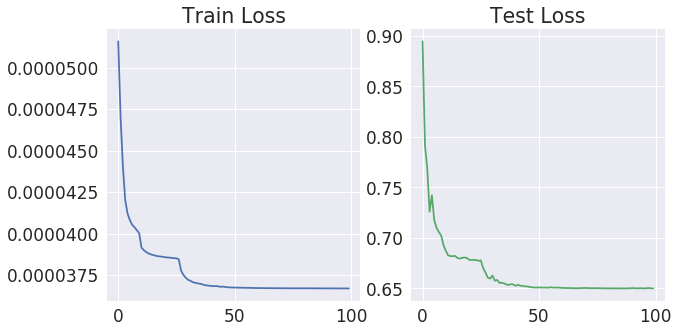

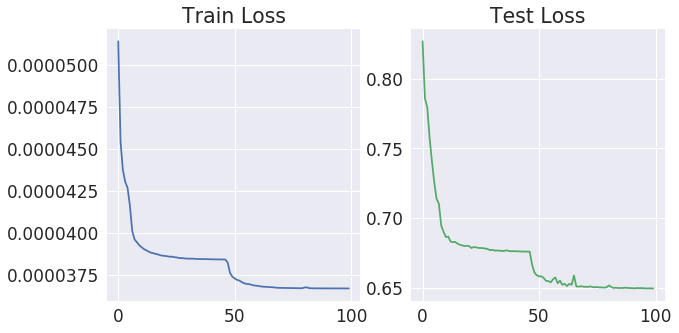

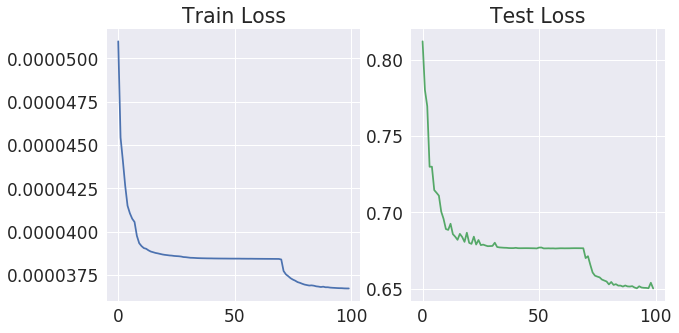

[[98.971 97.813]
 [98.911 97.88 ]
 [98.894 97.78 ]]
[98.926 97.824] [0.033 0.042]
7111.135369777679
79118


In [8]:
out_channels = 8
lr=0.005
momentum=0.9
num_epochs = 100 
start_time = time.time()
## Five random restarts
results = np.zeros((3, 2))
count = 0
for seed in [1,10,17]:
    device = 'cuda'
    torch.manual_seed(seed)
    device = torch.device(device)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    model = CNN3().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum) 

    train_loss = list()
    test_loss = list()
    train_acc = list()
    test_acc = list()
    for epoch in range(1, num_epochs + 1):
        tl, ta = train(model, train_loader, criterion, optimizer, epoch)
        train_loss.append(tl)
        train_acc.append(ta)
        testl, testa = test(model, test_loader, criterion, epoch)
        test_loss.append(testl)
        test_acc.append(testa)

    plt.figure(figsize = (10,5))
    plt.subplot(1,2,1)
    plt.plot(train_loss)
    plt.title('Train Loss')
    plt.subplot(1,2,2)
    plt.plot(test_loss, color = 'C1')
    plt.title('Test Loss')
    plt.show()
    ## Return final train and test accuracy
    results[count, :] = [ta, testa]
    count += 1
print(np.round(results, 3))
print(np.round(np.mean(results, axis = 0), 3), 
      np.round(np.std(results, axis = 0), 3))
end_time = time.time()
print(end_time - start_time)
## Count number of parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

In [9]:
## Cuda details
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

0
1
GeForce RTX 2080 Ti


# (2) Train Deep Models

Train and save models
- Regular convolution
- Deformable convolution
- Dilated 
- 1D Frequency
- 1D Time
- Feed forward

## Regular Convolution

In [7]:
class CNN(nn.Module): #(10, 20, 30) channels
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 5,
                              stride = 1, padding = 0)
        self.conv1_bn1 = nn.BatchNorm2d(10)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5, stride = 3, padding = 3)
        self.conv2_bn2 = nn.BatchNorm2d(20)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(20, 30, kernel_size = 5, stride = 2, padding = 0)
        self.conv3_bn3 = nn.BatchNorm2d(30)
        self.fc1 = nn.Linear(30 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 8)

    def forward(self, x):
#         print(x.shape)
        x = self.pool1(F.relu(self.conv1_bn1(self.conv1(x))))
#         print(x.shape)
        x = self.pool2(F.relu(self.conv2_bn2(self.conv2(x))))
#         print(x.shape)
        x = F.relu(self.conv3_bn3(self.conv3(x)))
#         print(x.shape)
        x = x.view(-1, 30*4*4)
#         print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

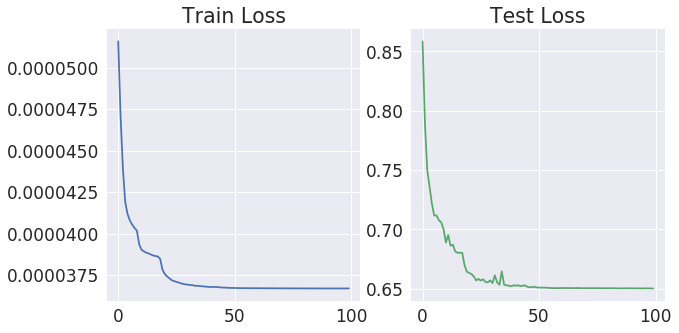

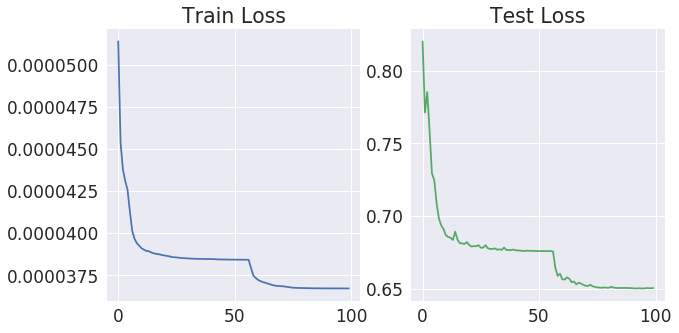

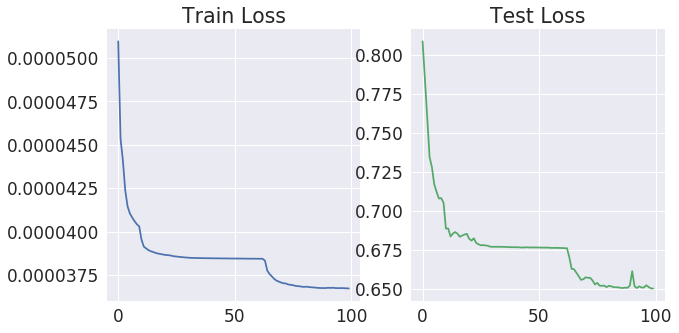

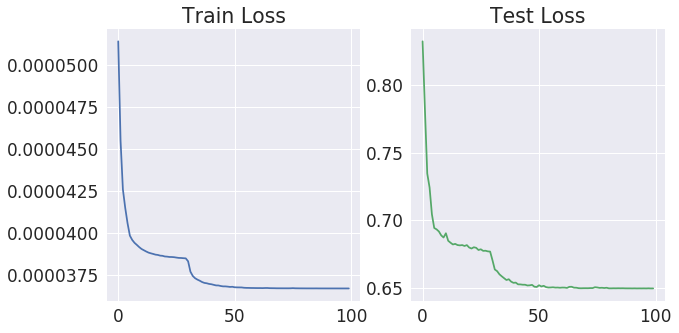

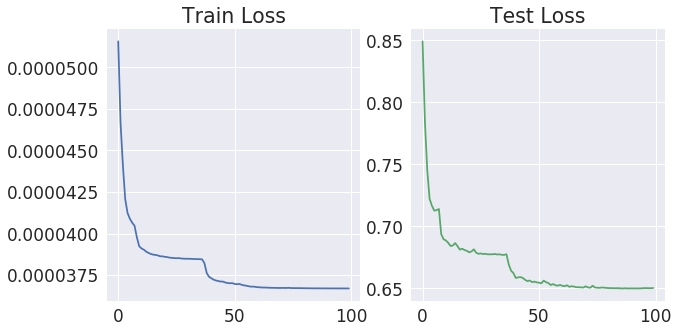

[[98.909 97.8  ]
 [98.88  97.713]
 [98.914 97.76 ]
 [98.9   97.853]
 [98.951 97.747]]
[98.911 97.775] [0.023 0.048]
10943.355221271515
79118


In [8]:
out_channels = 8
lr=0.005
momentum=0.9
num_epochs = 100
start_time = time.time()
## Five random restarts
results = np.zeros((5, 2))
count = 0
for seed in [1,10,17,25,177]:
    device = 'cuda'
    torch.manual_seed(seed)
    device = torch.device(device)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    model = CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum) 
    
    train_loss = list()
    test_loss = list()
    train_acc = list()
    test_acc = list()
    for epoch in range(1, num_epochs + 1):
        tl, ta = train(model, train_loader, criterion, optimizer, epoch)
        train_loss.append(tl)
        train_acc.append(ta)
        testl, testa = test(model, test_loader, criterion, epoch)
        test_loss.append(testl)
        test_acc.append(testa)
    
    ## Save trained model
    torch.save(model.state_dict(), 
               '../Deep-Features/NSynth/Regular-'+str(count)+'.pt')
    
    plt.figure(figsize = (10,5))
    plt.subplot(1,2,1)
    plt.plot(train_loss)
    plt.title('Train Loss')
    plt.subplot(1,2,2)
    plt.plot(test_loss, color = 'C1')
    plt.title('Test Loss')
    plt.show()
    ## Return final train and test accuracy
    results[count, :] = [ta, testa]
    count += 1

    
print(np.round(results, 3))
print(np.round(np.mean(results, axis = 0), 3), 
      np.round(np.std(results, axis = 0), 3))
end_time = time.time()
print(end_time - start_time)
## Count number of parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

## Deformable Convolution
Code from: https://github.com/4uiiurz1/pytorch-deform-conv-v2


In [7]:
class DeformConv2d(nn.Module):
    def __init__(self, inc, outc, kernel_size=3, padding=1, stride=1, bias=None, modulation=False):
        """
        Args:
            modulation (bool, optional): If True, Modulated Defomable Convolution (Deformable ConvNets v2).
        """
        super(DeformConv2d, self).__init__()
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        self.zero_padding = nn.ZeroPad2d(padding)
        self.conv = nn.Conv2d(inc, outc, kernel_size=kernel_size, stride=kernel_size, bias=bias)

        self.p_conv = nn.Conv2d(inc, 2*kernel_size*kernel_size, kernel_size=3, padding=1, stride=stride)
        nn.init.constant_(self.p_conv.weight, 0)
        self.p_conv.register_backward_hook(self._set_lr)

        self.modulation = modulation
        if modulation:
            self.m_conv = nn.Conv2d(inc, kernel_size*kernel_size, kernel_size=3, padding=1, stride=stride)
            nn.init.constant_(self.m_conv.weight, 0)
            self.m_conv.register_backward_hook(self._set_lr)

    @staticmethod
    def _set_lr(module, grad_input, grad_output):
        grad_input = (grad_input[i] * 0.1 for i in range(len(grad_input)))
        grad_output = (grad_output[i] * 0.1 for i in range(len(grad_output)))

    def forward(self, x):
        offset = self.p_conv(x)
        if self.modulation:
            m = torch.sigmoid(self.m_conv(x))

        dtype = offset.data.type()
        ks = self.kernel_size
        N = offset.size(1) // 2

        if self.padding:
            x = self.zero_padding(x)

        # (b, 2N, h, w)
        p = self._get_p(offset, dtype)

        # (b, h, w, 2N)
        p = p.contiguous().permute(0, 2, 3, 1)
        q_lt = p.detach().floor()
        q_rb = q_lt + 1

        q_lt = torch.cat([torch.clamp(q_lt[..., :N], 0, x.size(2)-1), torch.clamp(q_lt[..., N:], 0, x.size(3)-1)], dim=-1).long()
        q_rb = torch.cat([torch.clamp(q_rb[..., :N], 0, x.size(2)-1), torch.clamp(q_rb[..., N:], 0, x.size(3)-1)], dim=-1).long()
        q_lb = torch.cat([q_lt[..., :N], q_rb[..., N:]], dim=-1)
        q_rt = torch.cat([q_rb[..., :N], q_lt[..., N:]], dim=-1)

        # clip p
        p = torch.cat([torch.clamp(p[..., :N], 0, x.size(2)-1), torch.clamp(p[..., N:], 0, x.size(3)-1)], dim=-1)

        # bilinear kernel (b, h, w, N)
        g_lt = (1 + (q_lt[..., :N].type_as(p) - p[..., :N])) * (1 + (q_lt[..., N:].type_as(p) - p[..., N:]))
        g_rb = (1 - (q_rb[..., :N].type_as(p) - p[..., :N])) * (1 - (q_rb[..., N:].type_as(p) - p[..., N:]))
        g_lb = (1 + (q_lb[..., :N].type_as(p) - p[..., :N])) * (1 - (q_lb[..., N:].type_as(p) - p[..., N:]))
        g_rt = (1 - (q_rt[..., :N].type_as(p) - p[..., :N])) * (1 + (q_rt[..., N:].type_as(p) - p[..., N:]))

        # (b, c, h, w, N)
        x_q_lt = self._get_x_q(x, q_lt, N)
        x_q_rb = self._get_x_q(x, q_rb, N)
        x_q_lb = self._get_x_q(x, q_lb, N)
        x_q_rt = self._get_x_q(x, q_rt, N)

        # (b, c, h, w, N)
        x_offset = g_lt.unsqueeze(dim=1) * x_q_lt + \
                   g_rb.unsqueeze(dim=1) * x_q_rb + \
                   g_lb.unsqueeze(dim=1) * x_q_lb + \
                   g_rt.unsqueeze(dim=1) * x_q_rt

        # modulation
        if self.modulation:
            m = m.contiguous().permute(0, 2, 3, 1)
            m = m.unsqueeze(dim=1)
            m = torch.cat([m for _ in range(x_offset.size(1))], dim=1)
            x_offset *= m

        x_offset = self._reshape_x_offset(x_offset, ks)
        out = self.conv(x_offset)

        return out

    def _get_p_n(self, N, dtype):
        p_n_x, p_n_y = torch.meshgrid(
            torch.arange(-(self.kernel_size-1)//2, (self.kernel_size-1)//2+1),
            torch.arange(-(self.kernel_size-1)//2, (self.kernel_size-1)//2+1))
        # (2N, 1)
        p_n = torch.cat([torch.flatten(p_n_x), torch.flatten(p_n_y)], 0)
        p_n = p_n.view(1, 2*N, 1, 1).type(dtype)

        return p_n

    def _get_p_0(self, h, w, N, dtype):
        p_0_x, p_0_y = torch.meshgrid(
            torch.arange(1, h*self.stride+1, self.stride),
            torch.arange(1, w*self.stride+1, self.stride))
        p_0_x = torch.flatten(p_0_x).view(1, 1, h, w).repeat(1, N, 1, 1)
        p_0_y = torch.flatten(p_0_y).view(1, 1, h, w).repeat(1, N, 1, 1)
        p_0 = torch.cat([p_0_x, p_0_y], 1).type(dtype)

        return p_0

    def _get_p(self, offset, dtype):
        N, h, w = offset.size(1)//2, offset.size(2), offset.size(3)

        # (1, 2N, 1, 1)
        p_n = self._get_p_n(N, dtype)
        # (1, 2N, h, w)
        p_0 = self._get_p_0(h, w, N, dtype)
        p = p_0 + p_n + offset
        return p

    def _get_x_q(self, x, q, N):
        b, h, w, _ = q.size()
        padded_w = x.size(3)
        c = x.size(1)
        # (b, c, h*w)
        x = x.contiguous().view(b, c, -1)

        # (b, h, w, N)
        index = q[..., :N]*padded_w + q[..., N:]  # offset_x*w + offset_y
        # (b, c, h*w*N)
        index = index.contiguous().unsqueeze(dim=1).expand(-1, c, -1, -1, -1).contiguous().view(b, c, -1)

        x_offset = x.gather(dim=-1, index=index).contiguous().view(b, c, h, w, N)

        return x_offset

    @staticmethod
    def _reshape_x_offset(x_offset, ks):
        b, c, h, w, N = x_offset.size()
        x_offset = torch.cat([x_offset[..., s:s+ks].contiguous().view(b, c, h, w*ks) for s in range(0, N, ks)], dim=-1)
        x_offset = x_offset.contiguous().view(b, c, h*ks, w*ks)

        return x_offset

In [8]:
class CNN_deform(nn.Module):
    def __init__(self):
        super(CNN_deform, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 5,
                              stride = 1, padding = 0)
        self.conv1_bn1 = nn.BatchNorm2d(10)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5, stride = 3, padding = 3)
        self.conv2_bn2 = nn.BatchNorm2d(20)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DeformConv2d(20, 30, kernel_size = 5, stride = 2, padding = 0)
        self.conv3_bn3 = nn.BatchNorm2d(30)
        self.fc1 = nn.Linear(30 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 8)

    def forward(self, x):
#         print(x.shape)
        x = self.pool1(F.relu(self.conv1_bn1(self.conv1(x))))
#         print(x.shape)
        x = self.pool2(F.relu(self.conv2_bn2(self.conv2(x))))
#         print(x.shape)
        x = F.relu(self.conv3_bn3(self.conv3(x)))
#         print(x.shape)
        x = x.view(-1, 30*6*6)
#         print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

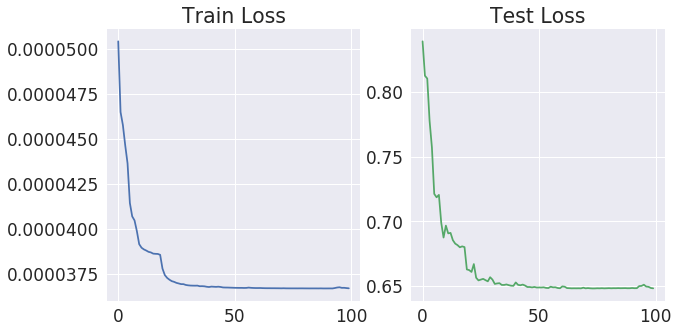

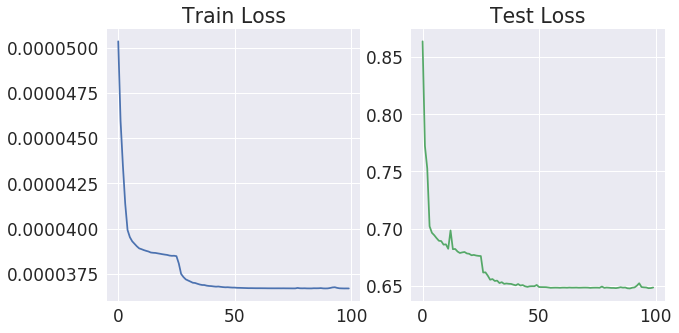

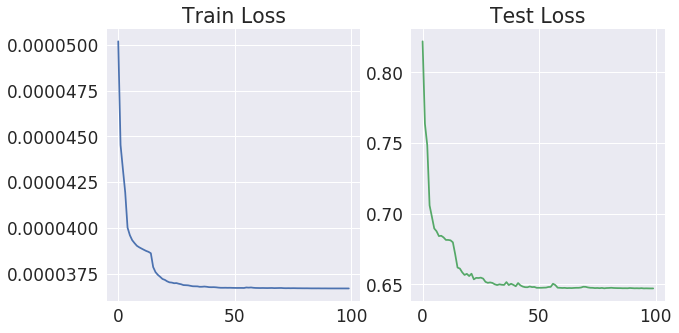

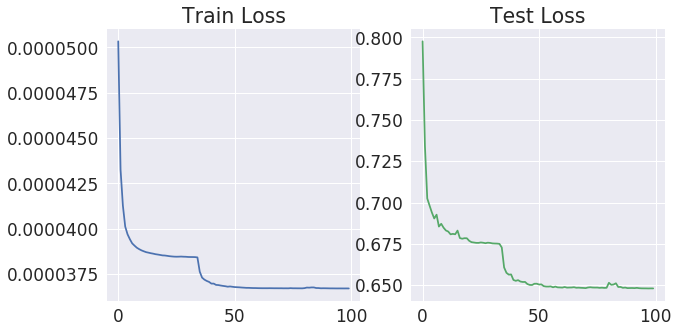

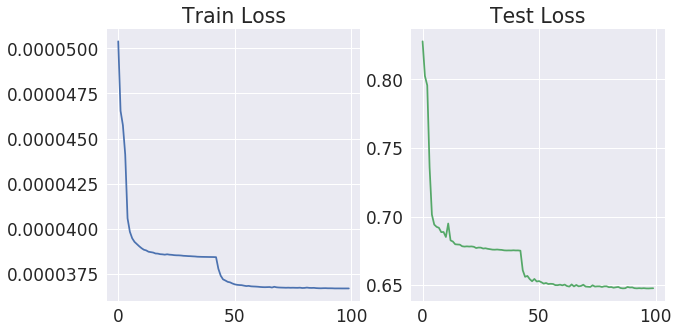

[[98.949 98.147]
 [98.971 98.153]
 [98.96  98.393]
 [98.931 98.12 ]
 [98.989 98.193]]
[98.96  98.201] [0.019 0.099]
18515.57632112503
160138


In [9]:
out_channels = 8
lr=0.005
momentum=0.9
num_epochs = 100
start_time = time.time()
## Five random restarts
results = np.zeros((5, 2))
count = 0
for seed in [1,10,17,25,177]:
    device = 'cuda'
    torch.manual_seed(seed)
    device = torch.device(device)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    model = CNN_deform().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum) 
    
    train_loss = list()
    test_loss = list()
    train_acc = list()
    test_acc = list()
    for epoch in range(1, num_epochs + 1):
        tl, ta = train(model, train_loader, criterion, optimizer, epoch)
        train_loss.append(tl)
        train_acc.append(ta)
        testl, testa = test(model, test_loader, criterion, epoch)
        test_loss.append(testl)
        test_acc.append(testa)
    
    ## Save trained model
    torch.save(model.state_dict(), 
               '../Deep-Features/NSynth/Deformable-'+str(count)+'.pt')
    
    plt.figure(figsize = (10,5))
    plt.subplot(1,2,1)
    plt.plot(train_loss)
    plt.title('Train Loss')
    plt.subplot(1,2,2)
    plt.plot(test_loss, color = 'C1')
    plt.title('Test Loss')
    plt.show()
    ## Return final train and test accuracy
    results[count, :] = [ta, testa]
    count += 1

    
print(np.round(results, 3))
print(np.round(np.mean(results, axis = 0), 3), 
      np.round(np.std(results, axis = 0), 3))
end_time = time.time()
print(end_time - start_time)
## Count number of parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

## Dilated Convolutions

In [6]:
class CNN_dilated(nn.Module): #(10, 20, 30) channels
    def __init__(self):
        super(CNN_dilated, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 5,
                              stride = 1, padding = 0, dilation = 3)
        self.conv1_bn1 = nn.BatchNorm2d(10)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5, stride = 2, padding = 3, 
                               dilation = 2)
        self.conv2_bn2 = nn.BatchNorm2d(20)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(20, 30, kernel_size = 5, stride = 2, padding = 1, 
                               dilation = 1)
        self.conv3_bn3 = nn.BatchNorm2d(30)
        self.fc1 = nn.Linear(30 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 8)

    def forward(self, x):
#         print(x.shape)
        x = self.pool1(F.relu(self.conv1_bn1(self.conv1(x))))
#         print(x.shape)
        x = self.pool2(F.relu(self.conv2_bn2(self.conv2(x))))
#         print(x.shape)
        x = F.relu(self.conv3_bn3(self.conv3(x)))
#         print(x.shape)
        x = x.view(-1, 30*6*6)
#         print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

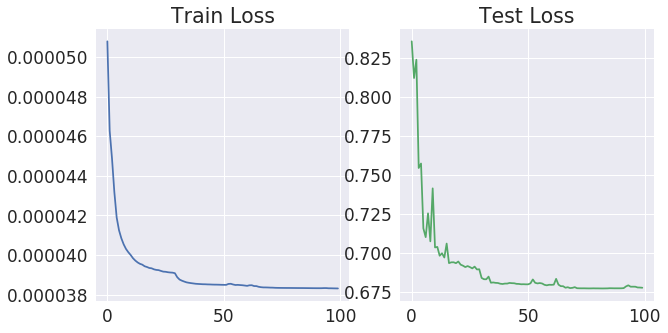

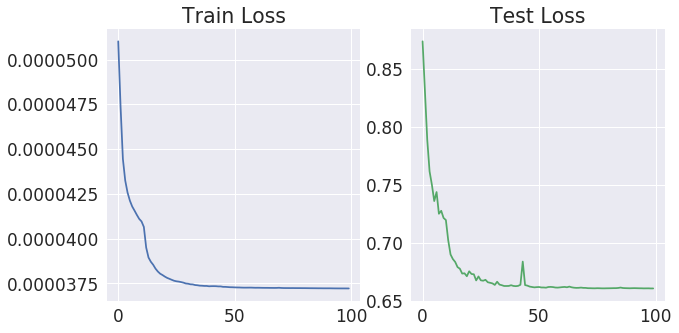

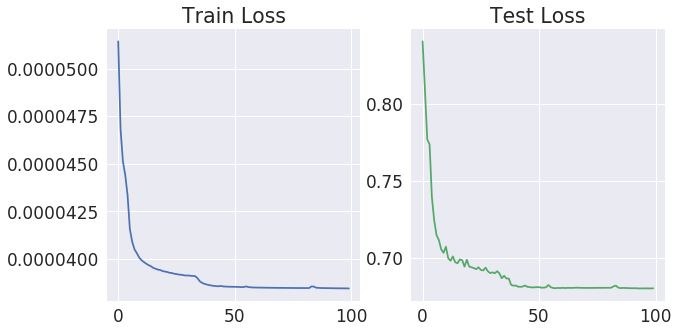

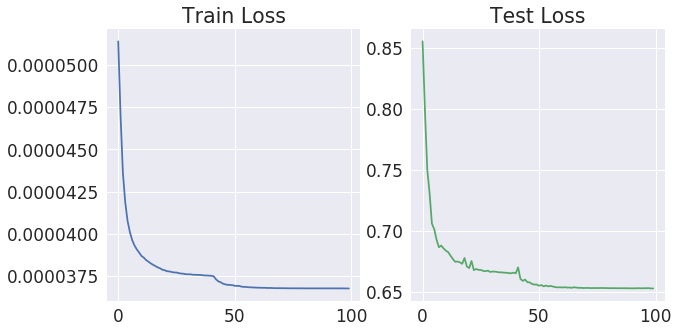

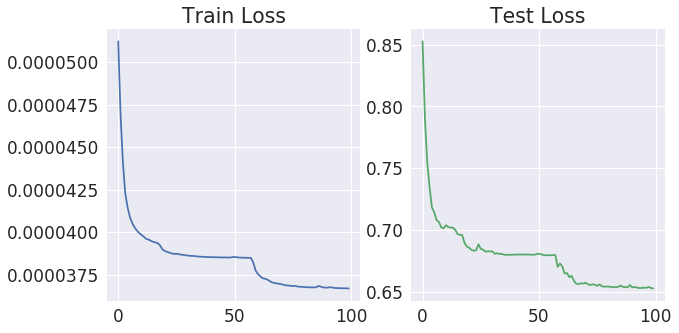

[[93.103 92.047]
 [97.097 95.687]
 [92.597 91.693]
 [98.749 97.227]
 [99.011 97.3  ]]
[96.111 94.791] [2.747 2.456]
9824.543500423431
151118


In [8]:
out_channels = 8
lr=0.005
momentum=0.9
num_epochs = 100
start_time = time.time()
## Five random restarts
results = np.zeros((5, 2))
count = 0
for seed in [1,10,17,25,177]:
    device = 'cuda'
    torch.manual_seed(seed)
    device = torch.device(device)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    model = CNN_dilated().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum) 
    
    train_loss = list()
    test_loss = list()
    train_acc = list()
    test_acc = list()
    for epoch in range(1, num_epochs + 1):
        tl, ta = train(model, train_loader, criterion, optimizer, epoch)
        train_loss.append(tl)
        train_acc.append(ta)
        testl, testa = test(model, test_loader, criterion, epoch)
        test_loss.append(testl)
        test_acc.append(testa)
    
    ## Save trained model
    torch.save(model.state_dict(), 
               '../Deep-Features/NSynth/Dilated-'+str(count)+'.pt')
    
    plt.figure(figsize = (10,5))
    plt.subplot(1,2,1)
    plt.plot(train_loss)
    plt.title('Train Loss')
    plt.subplot(1,2,2)
    plt.plot(test_loss, color = 'C1')
    plt.title('Test Loss')
    plt.show()
    ## Return final train and test accuracy
    results[count, :] = [ta, testa]
    count += 1

    
print(np.round(results, 3))
print(np.round(np.mean(results, axis = 0), 3), 
      np.round(np.std(results, axis = 0), 3))
end_time = time.time()
print(end_time - start_time)
## Count number of parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

## 1d Frequency

In [6]:
class CNN_1dF(nn.Module):
    def __init__(self):
        super(CNN_1dF, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = (5,1),
                              stride = 1, padding = 0, dilation = (3,1))
        self.conv1_bn1 = nn.BatchNorm2d(10)
        self.pool1 = nn.MaxPool2d((2,1))
        self.conv2 = nn.Conv2d(10, 20, kernel_size = (5,1), stride = (2,1), 
                               padding = (3,0), dilation = (2,1))
        self.conv2_bn2 = nn.BatchNorm2d(20)
        self.pool2 = nn.MaxPool2d((2,1))
        self.conv3 = nn.Conv2d(20, 30, kernel_size = (5,1), stride = (2,1), 
                               padding = (1,0), dilation = 1)
        self.conv3_bn3 = nn.BatchNorm2d(30)
        self.fc1 = nn.Linear(30 * 6 * 128, 120)
        self.fc2 = nn.Linear(120, 8)

    def forward(self, x):
#         print(x.shape)
        x = self.pool1(F.relu(self.conv1_bn1(self.conv1(x))))
#         print(x.shape)
        x = self.pool2(F.relu(self.conv2_bn2(self.conv2(x))))
#         print(x.shape)
        x = F.relu(self.conv3_bn3(self.conv3(x)))
#         print(x.shape)
        x = x.view(-1, 30*6*128)
#         print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

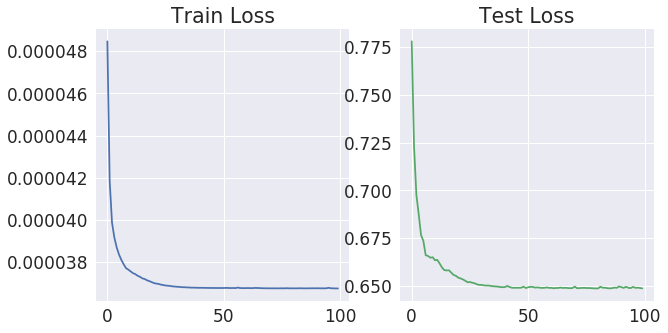

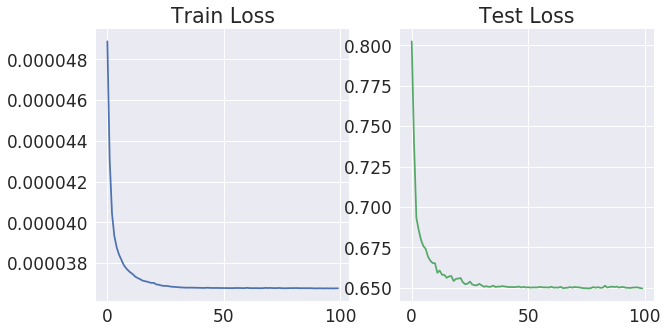

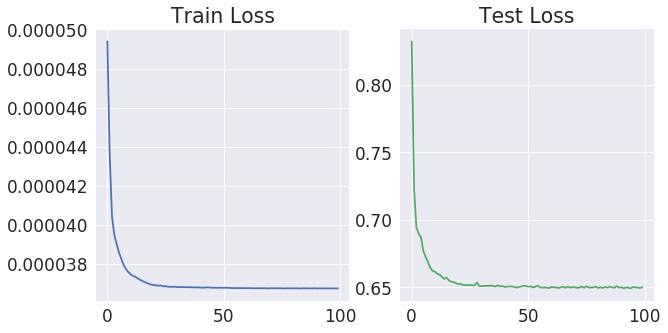

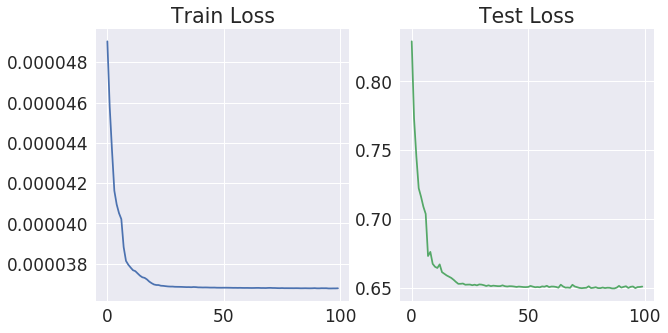

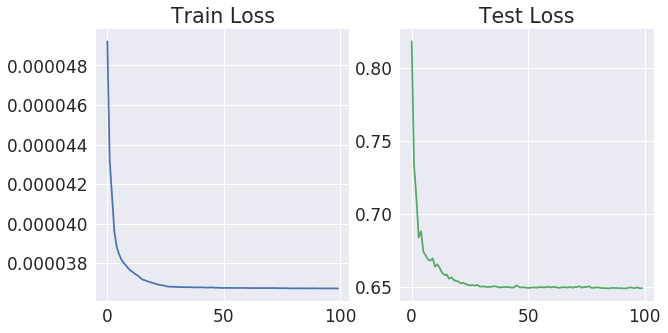

[[98.8   98.047]
 [98.717 97.853]
 [98.814 97.827]
 [98.694 97.687]
 [98.88  97.913]]
[98.781 97.865] [0.068 0.117]
9375.71673130989
2770118


In [8]:
out_channels = 8
lr=0.005
momentum=0.9
num_epochs = 100
start_time = time.time()
## Five random restarts
results = np.zeros((5, 2))
count = 0
for seed in [1,10,17,25,177]:
    device = 'cuda'
    torch.manual_seed(seed)
    device = torch.device(device)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    model = CNN_1dF().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum) 
    
    train_loss = list()
    test_loss = list()
    train_acc = list()
    test_acc = list()
    for epoch in range(1, num_epochs + 1):
        tl, ta = train(model, train_loader, criterion, optimizer, epoch)
        train_loss.append(tl)
        train_acc.append(ta)
        testl, testa = test(model, test_loader, criterion, epoch)
        test_loss.append(testl)
        test_acc.append(testa)
    
    ## Save trained model
    torch.save(model.state_dict(), 
               '../Deep-Features/NSynth/1dF-'+str(count)+'.pt')
    
    plt.figure(figsize = (10,5))
    plt.subplot(1,2,1)
    plt.plot(train_loss)
    plt.title('Train Loss')
    plt.subplot(1,2,2)
    plt.plot(test_loss, color = 'C1')
    plt.title('Test Loss')
    plt.show()
    ## Return final train and test accuracy
    results[count, :] = [ta, testa]
    count += 1

    
print(np.round(results, 3))
print(np.round(np.mean(results, axis = 0), 3), 
      np.round(np.std(results, axis = 0), 3))
end_time = time.time()
print(end_time - start_time)
## Count number of parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

## 1d Time

In [6]:
class CNN_1dT(nn.Module):
    def __init__(self):
        super(CNN_1dT, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = (1,5),
                              stride = 1, padding = 0, dilation = (1,3))
        self.conv1_bn1 = nn.BatchNorm2d(10)
        self.pool1 = nn.MaxPool2d((1,2))
        self.conv2 = nn.Conv2d(10, 20, kernel_size = (1,5), stride = (1,2), padding = (0,3), dilation = (1,2))
        self.conv2_bn2 = nn.BatchNorm2d(20)
        self.pool2 = nn.MaxPool2d((1,2))
        self.conv3 = nn.Conv2d(20, 30, kernel_size = (1,5), stride = (1,2), padding = (0,1), dilation = 1)
        self.conv3_bn3 = nn.BatchNorm2d(30)
        self.fc1 = nn.Linear(30 * 6 * 128, 120)
        self.fc2 = nn.Linear(120, 8)

    def forward(self, x):
#         print(x.shape)
        x = self.pool1(F.relu(self.conv1_bn1(self.conv1(x))))
#         print(x.shape)
        x = self.pool2(F.relu(self.conv2_bn2(self.conv2(x))))
#         print(x.shape)
        x = F.relu(self.conv3_bn3(self.conv3(x)))
#         print(x.shape)
        x = x.view(-1, 30*6*128)
#         print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

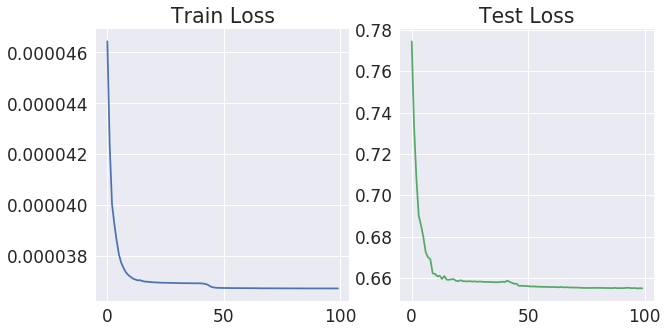

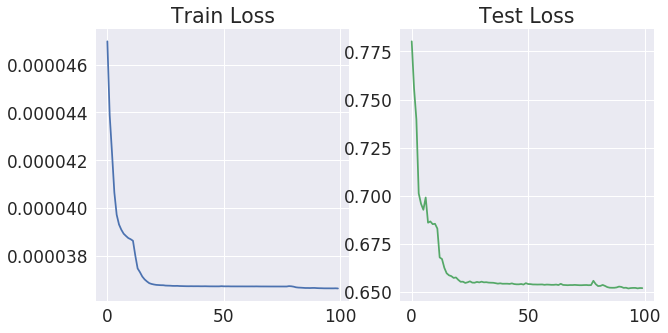

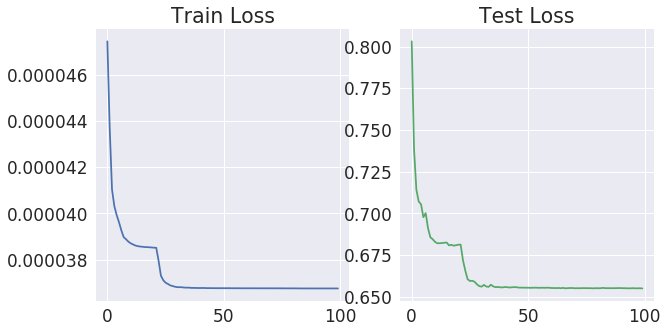

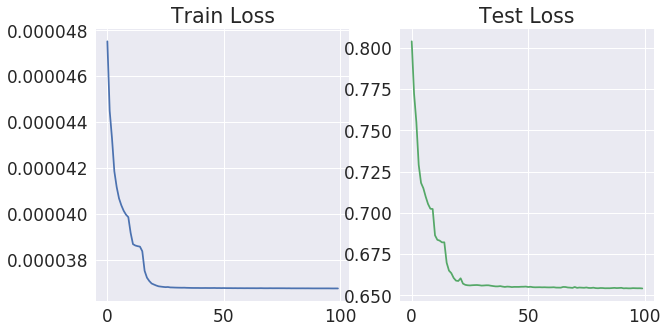

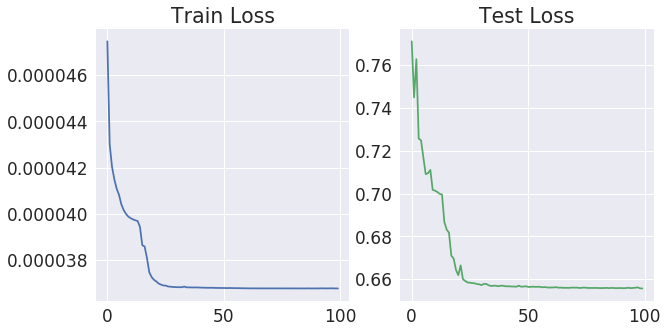

[[98.82  96.887]
 [99.111 97.5  ]
 [98.766 96.813]
 [98.803 97.02 ]
 [98.66  96.707]]
[98.832 96.985] [0.15  0.277]
9009.952541589737
2770118


In [10]:
out_channels = 8
lr=0.005
momentum=0.9
num_epochs = 100
start_time = time.time()
## Five random restarts
results = np.zeros((5, 2))
count = 0
for seed in [1,10,17,25,177]:
    device = 'cuda'
    torch.manual_seed(seed)
    device = torch.device(device)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    model = CNN_1dT().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum) 
    
    train_loss = list()
    test_loss = list()
    train_acc = list()
    test_acc = list()
    for epoch in range(1, num_epochs + 1):
        tl, ta = train(model, train_loader, criterion, optimizer, epoch)
        train_loss.append(tl)
        train_acc.append(ta)
        testl, testa = test(model, test_loader, criterion, epoch)
        test_loss.append(testl)
        test_acc.append(testa)
    
    ## Save trained model
    torch.save(model.state_dict(), 
               '../Deep-Features/NSynth/1dT-'+str(count)+'.pt')
    
    plt.figure(figsize = (10,5))
    plt.subplot(1,2,1)
    plt.plot(train_loss)
    plt.title('Train Loss')
    plt.subplot(1,2,2)
    plt.plot(test_loss, color = 'C1')
    plt.title('Test Loss')
    plt.show()
    ## Return final train and test accuracy
    results[count, :] = [ta, testa]
    count += 1

    
print(np.round(results, 3))
print(np.round(np.mean(results, axis = 0), 3), 
      np.round(np.std(results, axis = 0), 3))
end_time = time.time()
print(end_time - start_time)
## Count number of parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

## Feed Forward Baseline

In [11]:
def train_FF(model, train_loader, criterion, optimizer, epoch):
    train_loss = 0
    model.train()
    correct = 0
    loss_output = list()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(data.shape[0], data.shape[1]*data.shape[2]).to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
#         print(data.size(), output.size(), target.size())
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        
    train_loss = train_loss/(batch_idx+1)/len(train_loader.dataset)
    loss_output.append(train_loss)
    acc = 100. * correct / len(train_loader.dataset)
    return(loss_output, acc)

def test_FF(model, test_loader, criterion, epoch, batch_size = 32):
    model.eval()
    test_loss = 0
    correct = 0
    loss_output = list()
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(data.shape[0], data.shape[1]*data.shape[2]).to(device)
            target = target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss = (test_loss*batch_size)/len(test_loader.dataset)
    loss_output.append(test_loss)
    acc = 100. * correct / len(test_loader.dataset)
    return(loss_output, acc)

In [13]:
class feed_forward_class(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(feed_forward_class, self).__init__()
        self.fc1 = nn.Linear(in_features=in_channels, out_features= 120)
        self.bn1 = nn.BatchNorm1d(num_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=out_channels)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.softmax(self.fc2(x), dim = 1)
        return x

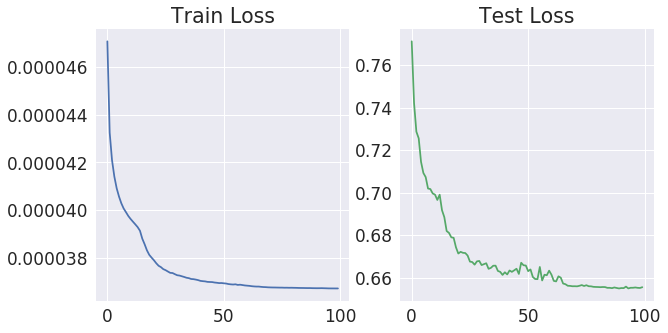

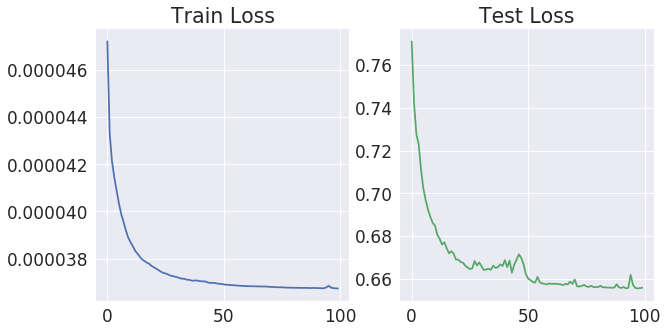

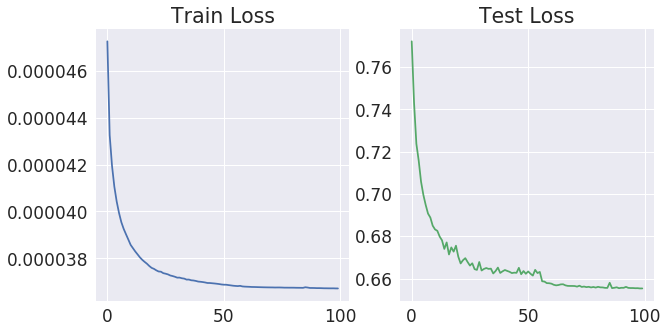

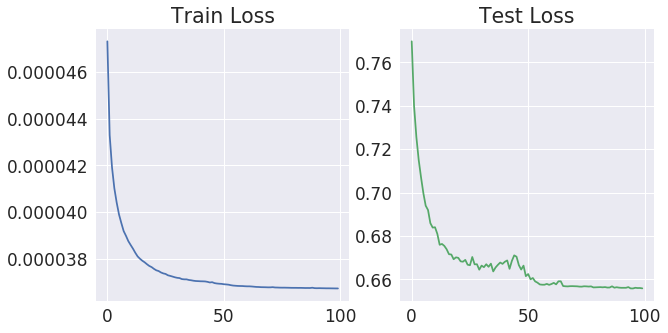

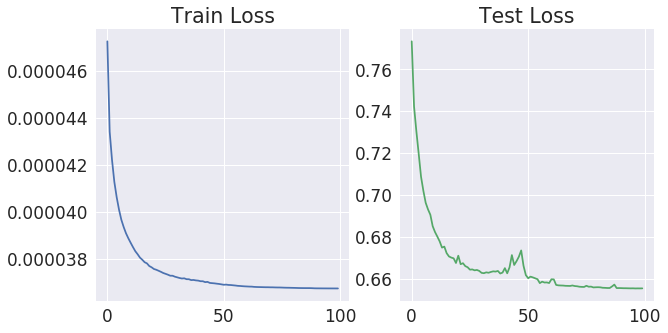

[[98.92  96.98 ]
 [98.874 96.807]
 [98.923 96.907]
 [98.877 96.893]
 [98.871 96.94 ]]
[98.893 96.905] [0.023 0.058]
6148.006801366806
1967408


In [13]:
in_channels = train_stft.shape[1]*train_stft.shape[2]
out_channels = 8
lr=0.005
momentum=0.9
num_epochs = 100
start_time = time.time()
## Five random restarts
results = np.zeros((5, 2))
count = 0
for seed in [1,10,17,25,177]:
    device = 'cuda'
    torch.manual_seed(seed)
    device = torch.device(device)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    model = feed_forward_class(in_channels, out_channels).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum) 
    
    train_loss = list()
    test_loss = list()
    train_acc = list()
    test_acc = list()
    for epoch in range(1, num_epochs + 1):
        tl, ta = train_FF(model, train_loader, criterion, optimizer, epoch)
        train_loss.append(tl)
        train_acc.append(ta)
        testl, testa = test_FF(model, test_loader, criterion, epoch)
        test_loss.append(testl)
        test_acc.append(testa)
    
    ## Save trained model
    torch.save(model.state_dict(), 
               '../Deep-Features/NSynth/FF-'+str(count)+'.pt')
    
    plt.figure(figsize = (10,5))
    plt.subplot(1,2,1)
    plt.plot(train_loss)
    plt.title('Train Loss')
    plt.subplot(1,2,2)
    plt.plot(test_loss, color = 'C1')
    plt.title('Test Loss')
    plt.show()
    ## Return final train and test accuracy
    results[count, :] = [ta, testa]
    count += 1

    
print(np.round(results, 3))
print(np.round(np.mean(results, axis = 0), 3), 
      np.round(np.std(results, axis = 0), 3))
end_time = time.time()
print(end_time - start_time)
## Count number of parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

# (3) Extract Deep Features and Use for Classification

- Need to reset activation dictionary after each model call
- If key error, can keep re-running cell for the layer name to be added to the dictionary

In [ ]:
## Extract deep features from trained models 
## and from untrained models with same seed initializations

In [7]:
# Extract feature maps
## https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def extract_features(data_loader, model):
    ## Initialize lists to store feature maps
    layer3 = list()
    target_list = list()
    for data, target in data_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        output = model(data)
        target_list.append(target)
        
        model.conv3.register_forward_hook(get_activation('conv3'))
        act = activation['conv3'].squeeze().detach().cpu().numpy()
        layer3.append(act)
    
    return(np.concatenate(layer3),np.hstack(target_list))

   

### Regular Convolutions


In [99]:
i = 0
model = CNN().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/Regular-'+str(i)+'.pt'))
model.eval()

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(3, 3), padding=(3, 3))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(5, 5), stride=(2, 2))
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [101]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Regular-'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Regular-'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 4, 4)
True
(15000, 30, 4, 4)
True


In [102]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [103]:
i = 1
model = CNN().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/Regular-'+str(i)+'.pt'))
model.eval()

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(3, 3), padding=(3, 3))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(5, 5), stride=(2, 2))
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [105]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Regular-'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Regular-'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 4, 4)
True
(15000, 30, 4, 4)
True


In [106]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [107]:
i = 2
model = CNN().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/Regular-'+str(i)+'.pt'))
model.eval()

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(3, 3), padding=(3, 3))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(5, 5), stride=(2, 2))
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [109]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Regular-'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Regular-'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 4, 4)
True
(15000, 30, 4, 4)
True


In [110]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [111]:
i = 3
model = CNN().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/Regular-'+str(i)+'.pt'))
model.eval()

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(3, 3), padding=(3, 3))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(5, 5), stride=(2, 2))
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [113]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Regular-'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Regular-'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 4, 4)
True
(15000, 30, 4, 4)
True


In [114]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [115]:
i = 4
model = CNN().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/Regular-'+str(i)+'.pt'))
model.eval()

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(3, 3), padding=(3, 3))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(5, 5), stride=(2, 2))
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [117]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Regular-'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Regular-'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 4, 4)
True
(15000, 30, 4, 4)
True


In [118]:
## Untrained models
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [122]:
i = 0
seed = 1
device = 'cuda'
torch.manual_seed(seed)
device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = CNN().to(device)

In [124]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Regular-U'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Regular-U'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

In [63]:
## Overall accuracy of untrained network
criterion = nn.CrossEntropyLoss()
correct = 0
with torch.no_grad():
    for data, target in train_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
train_acc = 100. * correct / len(train_loader.dataset)
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
test_acc = 100. * correct / len(test_loader.dataset)
print(np.round([train_acc, test_acc], 3))

[14.474 14.18 ]


In [64]:
## Untrained models
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [65]:
i = 1
seed = 10
torch.manual_seed(seed)
device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = CNN().to(device)

In [67]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Regular-U'+str(i)+'-train'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Regular-U'+str(i)+'-test'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 4, 4)
True
(15000, 30, 4, 4)
True


In [68]:
## Overall accuracy of untrained network
criterion = nn.CrossEntropyLoss()
correct = 0
with torch.no_grad():
    for data, target in train_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
train_acc = 100. * correct / len(train_loader.dataset)
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
test_acc = 100. * correct / len(test_loader.dataset)
print(np.round([train_acc, test_acc], 3))

[7.383 7.34 ]


In [69]:
## Untrained models
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [70]:
i = 2
seed = 17
torch.manual_seed(seed)
device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = CNN().to(device)

In [72]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Regular-U'+str(i)+'-train'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Regular-U'+str(i)+'-test'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 4, 4)
True
(15000, 30, 4, 4)
True


In [73]:
## Overall accuracy of untrained network
criterion = nn.CrossEntropyLoss()
correct = 0
with torch.no_grad():
    for data, target in train_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
train_acc = 100. * correct / len(train_loader.dataset)
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
test_acc = 100. * correct / len(test_loader.dataset)
print(np.round([train_acc, test_acc], 3))

[12.237 12.733]


In [74]:
## Untrained models
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [75]:
i = 3
seed = 25
torch.manual_seed(seed)
device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = CNN().to(device)

In [77]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Regular-U'+str(i)+'-train'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Regular-U'+str(i)+'-test'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 4, 4)
True
(15000, 30, 4, 4)
True


In [78]:
## Overall accuracy of untrained network
criterion = nn.CrossEntropyLoss()
correct = 0
with torch.no_grad():
    for data, target in train_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
train_acc = 100. * correct / len(train_loader.dataset)
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
test_acc = 100. * correct / len(test_loader.dataset)
print(np.round([train_acc, test_acc], 3))

[18.86 19.24]


In [79]:
## Untrained models
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [80]:
i = 4
seed = 177
torch.manual_seed(seed)
device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = CNN().to(device)

In [82]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Regular-U'+str(i)+'-train'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Regular-U'+str(i)+'-test'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 4, 4)
True
(15000, 30, 4, 4)
True


In [83]:
## Overall accuracy of untrained network
criterion = nn.CrossEntropyLoss()
correct = 0
with torch.no_grad():
    for data, target in train_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
train_acc = 100. * correct / len(train_loader.dataset)
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
test_acc = 100. * correct / len(test_loader.dataset)
print(np.round([train_acc, test_acc], 3))

[20.786 21.033]


In [89]:
## Overall Accuracy - Untrained
results = np.array([[14.474, 14.18 ], [7.383, 7.34 ], [12.237, 12.733],
                     [18.86, 19.24],[20.786, 21.033]])
print(np.round([np.mean(results, axis = 0), np.std(results, axis = 0)],3))

[[14.748 14.905]
 [ 4.775  4.875]]


### Deformable

In [13]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [15]:
i = 0
device = 'cuda'
model = CNN_deform().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/Deformable-'+str(i)+'.pt'))
model.eval()

CNN_deform(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(3, 3), padding=(3, 3))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): DeformConv2d(
    (zero_padding): ZeroPad2d(padding=(0, 0, 0, 0), value=0.0)
    (conv): Conv2d(20, 30, kernel_size=(5, 5), stride=(5, 5), bias=False)
    (p_conv): Conv2d(20, 50, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1080, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [17]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Deformable-'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Deformable-'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 6)
True
(15000, 30, 6, 6)
True


In [18]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [19]:
i = 1
model = CNN_deform().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/Deformable-'+str(i)+'.pt'))
model.eval()

CNN_deform(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(3, 3), padding=(3, 3))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): DeformConv2d(
    (zero_padding): ZeroPad2d(padding=(0, 0, 0, 0), value=0.0)
    (conv): Conv2d(20, 30, kernel_size=(5, 5), stride=(5, 5), bias=False)
    (p_conv): Conv2d(20, 50, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1080, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [21]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Deformable-'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Deformable-'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 6)
True
(15000, 30, 6, 6)
True


In [22]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [23]:
i = 2
model = CNN_deform().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/Deformable-'+str(i)+'.pt'))
model.eval()

CNN_deform(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(3, 3), padding=(3, 3))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): DeformConv2d(
    (zero_padding): ZeroPad2d(padding=(0, 0, 0, 0), value=0.0)
    (conv): Conv2d(20, 30, kernel_size=(5, 5), stride=(5, 5), bias=False)
    (p_conv): Conv2d(20, 50, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1080, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [25]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Deformable-'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Deformable-'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 6)
True
(15000, 30, 6, 6)
True


In [26]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [27]:
i = 3
model = CNN_deform().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/Deformable-'+str(i)+'.pt'))
model.eval()

CNN_deform(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(3, 3), padding=(3, 3))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): DeformConv2d(
    (zero_padding): ZeroPad2d(padding=(0, 0, 0, 0), value=0.0)
    (conv): Conv2d(20, 30, kernel_size=(5, 5), stride=(5, 5), bias=False)
    (p_conv): Conv2d(20, 50, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1080, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [29]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Deformable-'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Deformable-'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 6)
True
(15000, 30, 6, 6)
True


In [30]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [32]:
i = 4
model = CNN_deform().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/Deformable-'+str(i)+'.pt'))
model.eval()

CNN_deform(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(3, 3), padding=(3, 3))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): DeformConv2d(
    (zero_padding): ZeroPad2d(padding=(0, 0, 0, 0), value=0.0)
    (conv): Conv2d(20, 30, kernel_size=(5, 5), stride=(5, 5), bias=False)
    (p_conv): Conv2d(20, 50, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1080, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [34]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Deformable-'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Deformable-'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 6)
True
(15000, 30, 6, 6)
True


In [35]:
## Untrained models
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [36]:
i = 0
seed = 1
device = 'cuda'
torch.manual_seed(seed)
device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = CNN_deform().to(device)

In [38]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Deformable-U'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Deformable-U'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 6)
True
(15000, 30, 6, 6)
True


In [39]:
## Overall accuracy of untrained network
results = np.zeros((5,2))
criterion = nn.CrossEntropyLoss()
correct = 0
with torch.no_grad():
    for data, target in train_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
train_acc = 100. * correct / len(train_loader.dataset)
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
test_acc = 100. * correct / len(test_loader.dataset)
print(np.round([train_acc, test_acc], 3))
results[i,:] = [train_acc, test_acc]

[27.223 27.14 ]


In [40]:
## Untrained models
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [41]:
i = 1
seed = 10
torch.manual_seed(seed)
device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = CNN_deform().to(device)

In [43]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Deformable-U'+str(i)+'-train'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Deformable-U'+str(i)+'-test'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 6)
True
(15000, 30, 6, 6)
True


In [44]:
## Overall accuracy of untrained network
criterion = nn.CrossEntropyLoss()
correct = 0
with torch.no_grad():
    for data, target in train_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
train_acc = 100. * correct / len(train_loader.dataset)
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
test_acc = 100. * correct / len(test_loader.dataset)
print(np.round([train_acc, test_acc], 3))
results[i,:] = [train_acc, test_acc]

[14.969 15.   ]


In [45]:
## Untrained models
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [46]:
i = 2
seed = 17
torch.manual_seed(seed)
device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = CNN_deform().to(device)

In [48]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Deformable-U'+str(i)+'-train'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Deformable-U'+str(i)+'-test'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 6)
True
(15000, 30, 6, 6)
True


In [49]:
## Overall accuracy of untrained network
criterion = nn.CrossEntropyLoss()
correct = 0
with torch.no_grad():
    for data, target in train_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
train_acc = 100. * correct / len(train_loader.dataset)
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
test_acc = 100. * correct / len(test_loader.dataset)
print(np.round([train_acc, test_acc], 3))
results[i,:] = [train_acc, test_acc]

[14.48 14.66]


In [12]:
## Untrained models
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [13]:
i = 3
seed = 25
device = 'cuda'
torch.manual_seed(seed)
device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = CNN_deform().to(device)

In [15]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Deformable-U'+str(i)+'-train'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Deformable-U'+str(i)+'-test'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 6)
True
(15000, 30, 6, 6)
True


In [17]:
## Overall accuracy of untrained network
criterion = nn.CrossEntropyLoss()
correct = 0
with torch.no_grad():
    for data, target in train_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
train_acc = 100. * correct / len(train_loader.dataset)
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
test_acc = 100. * correct / len(test_loader.dataset)
print(np.round([train_acc, test_acc], 3))
results[i,:] = [train_acc, test_acc]

[8.326 7.927]


In [18]:
## Untrained models
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [19]:
i = 4
seed = 177
torch.manual_seed(seed)
device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = CNN_deform().to(device)

In [21]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Deformable-U'+str(i)+'-train'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Deformable-U'+str(i)+'-test'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 6)
True
(15000, 30, 6, 6)
True


In [22]:
## Overall accuracy of untrained network
criterion = nn.CrossEntropyLoss()
correct = 0
with torch.no_grad():
    for data, target in train_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
train_acc = 100. * correct / len(train_loader.dataset)
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
test_acc = 100. * correct / len(test_loader.dataset)
print(np.round([train_acc, test_acc], 3))
results[i,:] = [train_acc, test_acc]

[21.829 22.027]


In [25]:
## Overall Accuracy - Untrained
print(np.round([np.mean(results, axis = 0), np.std(results, axis = 0)],3))

[[17.365 17.351]
 [ 6.525  6.622]]


### Dilated

In [27]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [28]:
i = 0
device = 'cuda'
model = CNN_dilated().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/Dilated-'+str(i)+'.pt'))
model.eval()

CNN_dilated(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), dilation=(3, 3))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3), dilation=(2, 2))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1080, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [30]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Dilated-'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Dilated-'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 6)
True
(15000, 30, 6, 6)
True


In [31]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [32]:
i = 1
model = CNN_dilated().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/Dilated-'+str(i)+'.pt'))
model.eval()

CNN_dilated(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), dilation=(3, 3))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3), dilation=(2, 2))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1080, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [34]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Dilated-'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Dilated-'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 6)
True
(15000, 30, 6, 6)
True


In [35]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [36]:
i = 2
model = CNN_dilated().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/Dilated-'+str(i)+'.pt'))
model.eval()

CNN_dilated(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), dilation=(3, 3))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3), dilation=(2, 2))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1080, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [38]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Dilated-'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Dilated-'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 6)
True
(15000, 30, 6, 6)
True


In [39]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [40]:
i = 3
model = CNN_dilated().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/Dilated-'+str(i)+'.pt'))
model.eval()

CNN_dilated(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), dilation=(3, 3))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3), dilation=(2, 2))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1080, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [42]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Dilated-'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Dilated-'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 6)
True
(15000, 30, 6, 6)
True


In [43]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [44]:
i = 4
model = CNN_dilated().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/Dilated-'+str(i)+'.pt'))
model.eval()

CNN_dilated(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), dilation=(3, 3))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3), dilation=(2, 2))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1080, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [46]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Dilated-'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Dilated-'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 6)
True
(15000, 30, 6, 6)
True


In [47]:
## Untrained models
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [48]:
i = 0
seed = 1
device = 'cuda'
torch.manual_seed(seed)
device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = CNN_dilated().to(device)

In [50]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Dilated-U'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Dilated-U'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 6)
True
(15000, 30, 6, 6)
True


In [51]:
## Overall accuracy of untrained network
results = np.zeros((5,2))
criterion = nn.CrossEntropyLoss()
correct = 0
with torch.no_grad():
    for data, target in train_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
train_acc = 100. * correct / len(train_loader.dataset)
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
test_acc = 100. * correct / len(test_loader.dataset)
print(np.round([train_acc, test_acc], 3))
results[i,:] = [train_acc, test_acc]

[10.749 10.667]


In [52]:
## Untrained models
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [53]:
i = 1
seed = 10
torch.manual_seed(seed)
device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = CNN_dilated().to(device)

In [55]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Dilated-U'+str(i)+'-train'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Dilated-U'+str(i)+'-test'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 6)
True
(15000, 30, 6, 6)
True


In [56]:
## Overall accuracy of untrained network
criterion = nn.CrossEntropyLoss()
correct = 0
with torch.no_grad():
    for data, target in train_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
train_acc = 100. * correct / len(train_loader.dataset)
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
test_acc = 100. * correct / len(test_loader.dataset)
print(np.round([train_acc, test_acc], 3))
results[i,:] = [train_acc, test_acc]

[6.451 6.04 ]


In [57]:
## Untrained models
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [58]:
i = 2
seed = 17
torch.manual_seed(seed)
device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = CNN_dilated().to(device)

In [60]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Dilated-U'+str(i)+'-train'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Dilated-U'+str(i)+'-test'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 6)
True
(15000, 30, 6, 6)
True


In [61]:
## Overall accuracy of untrained network
criterion = nn.CrossEntropyLoss()
correct = 0
with torch.no_grad():
    for data, target in train_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
train_acc = 100. * correct / len(train_loader.dataset)
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
test_acc = 100. * correct / len(test_loader.dataset)
print(np.round([train_acc, test_acc], 3))
results[i,:] = [train_acc, test_acc]

[13.269 13.107]


In [11]:
## Untrained models
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [12]:
i = 3
seed = 25
device = 'cuda'
torch.manual_seed(seed)
device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = CNN_dilated().to(device)

In [15]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Dilated-U'+str(i)+'-train'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Dilated-U'+str(i)+'-test'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 6)
True
(15000, 30, 6, 6)
True


In [16]:
## Overall accuracy of untrained network
criterion = nn.CrossEntropyLoss()
correct = 0
with torch.no_grad():
    for data, target in train_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
train_acc = 100. * correct / len(train_loader.dataset)
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
test_acc = 100. * correct / len(test_loader.dataset)
print(np.round([train_acc, test_acc], 3))
results[i,:] = [train_acc, test_acc]

[9.271 8.867]


In [17]:
## Untrained models
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [18]:
i = 4
seed = 177
torch.manual_seed(seed)
device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = CNN_dilated().to(device)

In [20]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/Dilated-U'+str(i)+'-train'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/Dilated-U'+str(i)+'-test'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 6)
True
(15000, 30, 6, 6)
True


In [21]:
## Overall accuracy of untrained network
criterion = nn.CrossEntropyLoss()
correct = 0
with torch.no_grad():
    for data, target in train_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
train_acc = 100. * correct / len(train_loader.dataset)
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
test_acc = 100. * correct / len(test_loader.dataset)
print(np.round([train_acc, test_acc], 3))
results[i,:] = [train_acc, test_acc]

[13.546 13.833]


In [23]:
## Overall Accuracy - Untrained
print(np.round([np.mean(results, axis = 0), np.std(results, axis = 0)],3))

[[10.657 10.503]
 [ 2.638  2.846]]


## 1dF

In [24]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [25]:
i = 0
device = 'cuda'
model = CNN_1dF().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/1dF-'+str(i)+'.pt'))
model.eval()

CNN_1dF(
  (conv1): Conv2d(1, 10, kernel_size=(5, 1), stride=(1, 1), dilation=(3, 1))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 1), stride=(2, 1), padding=(3, 0), dilation=(2, 1))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(5, 1), stride=(2, 1), padding=(1, 0))
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=23040, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [27]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/1dF-'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/1dF-'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 128)
True
(15000, 30, 6, 128)
True


In [28]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [29]:
i = 1
model = CNN_1dF().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/1dF-'+str(i)+'.pt'))
model.eval()

CNN_1dF(
  (conv1): Conv2d(1, 10, kernel_size=(5, 1), stride=(1, 1), dilation=(3, 1))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 1), stride=(2, 1), padding=(3, 0), dilation=(2, 1))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(5, 1), stride=(2, 1), padding=(1, 0))
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=23040, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [31]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/1dF-'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/1dF-'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 128)
True
(15000, 30, 6, 128)
True


In [32]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [33]:
i = 2
model = CNN_1dF().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/1dF-'+str(i)+'.pt'))
model.eval()

CNN_1dF(
  (conv1): Conv2d(1, 10, kernel_size=(5, 1), stride=(1, 1), dilation=(3, 1))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 1), stride=(2, 1), padding=(3, 0), dilation=(2, 1))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(5, 1), stride=(2, 1), padding=(1, 0))
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=23040, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [35]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/1dF-'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/1dF-'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 128)
True
(15000, 30, 6, 128)
True


In [36]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [37]:
i = 3
model = CNN_1dF().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/1dF-'+str(i)+'.pt'))
model.eval()

CNN_1dF(
  (conv1): Conv2d(1, 10, kernel_size=(5, 1), stride=(1, 1), dilation=(3, 1))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 1), stride=(2, 1), padding=(3, 0), dilation=(2, 1))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(5, 1), stride=(2, 1), padding=(1, 0))
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=23040, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [39]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/1dF-'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/1dF-'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 128)
True
(15000, 30, 6, 128)
True


In [40]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [41]:
i = 4
model = CNN_1dF().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/1dF-'+str(i)+'.pt'))
model.eval()

CNN_1dF(
  (conv1): Conv2d(1, 10, kernel_size=(5, 1), stride=(1, 1), dilation=(3, 1))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 1), stride=(2, 1), padding=(3, 0), dilation=(2, 1))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(5, 1), stride=(2, 1), padding=(1, 0))
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=23040, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [43]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/1dF-'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/1dF-'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 128)
True
(15000, 30, 6, 128)
True


In [9]:
## Untrained models
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [10]:
i = 0
seed = 1
device = 'cuda'
torch.manual_seed(seed)
device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = CNN_1dF().to(device)

In [12]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/1dF-U'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/1dF-U'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 128)
True
(15000, 30, 6, 128)
True


In [13]:
## Overall accuracy of untrained network
results = np.zeros((5,2))
criterion = nn.CrossEntropyLoss()
correct = 0
with torch.no_grad():
    for data, target in train_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
train_acc = 100. * correct / len(train_loader.dataset)
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
test_acc = 100. * correct / len(test_loader.dataset)
print(np.round([train_acc, test_acc], 3))
results[i,:] = [train_acc, test_acc]

[9.871 9.833]


In [14]:
## Untrained models
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [15]:
i = 1
seed = 10
torch.manual_seed(seed)
device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = CNN_1dF().to(device)

In [17]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/1dF-U'+str(i)+'-train'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/1dF-U'+str(i)+'-test'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 128)
True
(15000, 30, 6, 128)
True


In [18]:
## Overall accuracy of untrained network
criterion = nn.CrossEntropyLoss()
correct = 0
with torch.no_grad():
    for data, target in train_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
train_acc = 100. * correct / len(train_loader.dataset)
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
test_acc = 100. * correct / len(test_loader.dataset)
print(np.round([train_acc, test_acc], 3))
results[i,:] = [train_acc, test_acc]

[11.309 11.333]


In [19]:
## Untrained models
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [20]:
i = 2
seed = 17
torch.manual_seed(seed)
device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = CNN_1dF().to(device)

In [22]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/1dF-U'+str(i)+'-train'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/1dF-U'+str(i)+'-test'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 128)
True
(15000, 30, 6, 128)
True


In [23]:
## Overall accuracy of untrained network
criterion = nn.CrossEntropyLoss()
correct = 0
with torch.no_grad():
    for data, target in train_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
train_acc = 100. * correct / len(train_loader.dataset)
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
test_acc = 100. * correct / len(test_loader.dataset)
print(np.round([train_acc, test_acc], 3))
results[i,:] = [train_acc, test_acc]

[10.903 10.5  ]


In [24]:
## Untrained models
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [25]:
i = 3
seed = 25
device = 'cuda'
torch.manual_seed(seed)
device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = CNN_1dF().to(device)

In [27]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/1dF-U'+str(i)+'-train'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/1dF-U'+str(i)+'-test'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 128)
True
(15000, 30, 6, 128)
True


In [28]:
## Overall accuracy of untrained network
criterion = nn.CrossEntropyLoss()
correct = 0
with torch.no_grad():
    for data, target in train_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
train_acc = 100. * correct / len(train_loader.dataset)
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
test_acc = 100. * correct / len(test_loader.dataset)
print(np.round([train_acc, test_acc], 3))
results[i,:] = [train_acc, test_acc]

[23.191 23.213]


In [29]:
## Untrained models
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [30]:
i = 4
seed = 177
torch.manual_seed(seed)
device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = CNN_1dF().to(device)

In [32]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/1dF-U'+str(i)+'-train'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/1dF-U'+str(i)+'-test'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 6, 128)
True
(15000, 30, 6, 128)
True


In [33]:
## Overall accuracy of untrained network
criterion = nn.CrossEntropyLoss()
correct = 0
with torch.no_grad():
    for data, target in train_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
train_acc = 100. * correct / len(train_loader.dataset)
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
test_acc = 100. * correct / len(test_loader.dataset)
print(np.round([train_acc, test_acc], 3))
results[i,:] = [train_acc, test_acc]

[8.146 8.173]


In [34]:
## Overall Accuracy - Untrained
print(np.round([np.mean(results, axis = 0), np.std(results, axis = 0)],3))

[[12.684 12.611]
 [ 5.366  5.402]]


### 1dT

In [35]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [36]:
i = 0
device = 'cuda'
model = CNN_1dT().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/1dT-'+str(i)+'.pt'))
model.eval()

CNN_1dT(
  (conv1): Conv2d(1, 10, kernel_size=(1, 5), stride=(1, 1), dilation=(1, 3))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(1, 5), stride=(1, 2), padding=(0, 3), dilation=(1, 2))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(1, 5), stride=(1, 2), padding=(0, 1))
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=23040, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [38]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/1dT-'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/1dT-'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 128, 6)
True
(15000, 30, 128, 6)
True


In [8]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [9]:
i = 1
device = 'cuda'
model = CNN_1dT().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/1dT-'+str(i)+'.pt'))
model.eval()

CNN_1dT(
  (conv1): Conv2d(1, 10, kernel_size=(1, 5), stride=(1, 1), dilation=(1, 3))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(1, 5), stride=(1, 2), padding=(0, 3), dilation=(1, 2))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(1, 5), stride=(1, 2), padding=(0, 1))
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=23040, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [11]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/1dT-'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/1dT-'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 128, 6)
True
(15000, 30, 128, 6)
True


In [12]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [13]:
i = 2
model = CNN_1dT().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/1dT-'+str(i)+'.pt'))
model.eval()

CNN_1dT(
  (conv1): Conv2d(1, 10, kernel_size=(1, 5), stride=(1, 1), dilation=(1, 3))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(1, 5), stride=(1, 2), padding=(0, 3), dilation=(1, 2))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(1, 5), stride=(1, 2), padding=(0, 1))
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=23040, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [15]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/1dT-'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/1dT-'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 128, 6)
True
(15000, 30, 128, 6)
True


In [16]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [17]:
i = 3
model = CNN_1dT().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/1dT-'+str(i)+'.pt'))
model.eval()

CNN_1dT(
  (conv1): Conv2d(1, 10, kernel_size=(1, 5), stride=(1, 1), dilation=(1, 3))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(1, 5), stride=(1, 2), padding=(0, 3), dilation=(1, 2))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(1, 5), stride=(1, 2), padding=(0, 1))
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=23040, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [19]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/1dT-'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/1dT-'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 128, 6)
True
(15000, 30, 128, 6)
True


In [20]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [21]:
i = 4
model = CNN_1dT().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/1dT-'+str(i)+'.pt'))
model.eval()

CNN_1dT(
  (conv1): Conv2d(1, 10, kernel_size=(1, 5), stride=(1, 1), dilation=(1, 3))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(1, 5), stride=(1, 2), padding=(0, 3), dilation=(1, 2))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(1, 5), stride=(1, 2), padding=(0, 1))
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=23040, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [23]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/1dT-'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/1dT-'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 128, 6)
True
(15000, 30, 128, 6)
True


In [24]:
## Untrained models
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [25]:
i = 0
seed = 1
device = 'cuda'
torch.manual_seed(seed)
device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = CNN_1dT().to(device)

In [27]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/1dT-U'+str(i)+'-train'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/1dT-U'+str(i)+'-test'
np.savez(fname, l3.astype('float32'), targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 128, 6)
True
(15000, 30, 128, 6)
True


In [28]:
## Overall accuracy of untrained network
results = np.zeros((5,2))
criterion = nn.CrossEntropyLoss()
correct = 0
with torch.no_grad():
    for data, target in train_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
train_acc = 100. * correct / len(train_loader.dataset)
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
test_acc = 100. * correct / len(test_loader.dataset)
print(np.round([train_acc, test_acc], 3))
results[i,:] = [train_acc, test_acc]

[10.857 10.127]


In [29]:
## Untrained models
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [8]:
i = 1
seed = 10
device = 'cuda'
torch.manual_seed(seed)
device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = CNN_1dT().to(device)

In [10]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/1dT-U'+str(i)+'-train'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/1dT-U'+str(i)+'-test'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 128, 6)
True
(15000, 30, 128, 6)
True


In [11]:
## Overall accuracy of untrained network
criterion = nn.CrossEntropyLoss()
correct = 0
with torch.no_grad():
    for data, target in train_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
train_acc = 100. * correct / len(train_loader.dataset)
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
test_acc = 100. * correct / len(test_loader.dataset)
print(np.round([train_acc, test_acc], 3))
results[i,:] = [train_acc, test_acc]

[17.08 17.04]


NameError: name 'results' is not defined

In [13]:
## Untrained models
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [14]:
i = 2
seed = 17
torch.manual_seed(seed)
device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = CNN_1dT().to(device)

In [16]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/1dT-U'+str(i)+'-train'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/1dT-U'+str(i)+'-test'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 128, 6)
True
(15000, 30, 128, 6)
True


In [17]:
## Overall accuracy of untrained network
criterion = nn.CrossEntropyLoss()
correct = 0
with torch.no_grad():
    for data, target in train_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
train_acc = 100. * correct / len(train_loader.dataset)
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
test_acc = 100. * correct / len(test_loader.dataset)
print(np.round([train_acc, test_acc], 3))
results[i,:] = [train_acc, test_acc]

[10.994 10.733]


In [18]:
## Untrained models
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [19]:
i = 3
seed = 25
torch.manual_seed(seed)
device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = CNN_1dT().to(device)

In [21]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/1dT-U'+str(i)+'-train'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/1dT-U'+str(i)+'-test'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 128, 6)
True
(15000, 30, 128, 6)
True


In [22]:
## Overall accuracy of untrained network
criterion = nn.CrossEntropyLoss()
correct = 0
with torch.no_grad():
    for data, target in train_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
train_acc = 100. * correct / len(train_loader.dataset)
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
test_acc = 100. * correct / len(test_loader.dataset)
print(np.round([train_acc, test_acc], 3))
results[i,:] = [train_acc, test_acc]

[23.769 24.32 ]


In [23]:
## Untrained models
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [24]:
i = 4
seed = 177
torch.manual_seed(seed)
device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = CNN_1dT().to(device)

In [26]:
l3, targets = extract_features(train_loader, model)
fname = '../Deep-Features/NSynth/1dT-U'+str(i)+'-train'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == train_trans))
l3, targets = extract_features(test_loader, model)
fname = '../Deep-Features/NSynth/1dT-U'+str(i)+'-test'
np.savez(fname, l3, targets)
print(l3.shape)
print(np.all(targets == test_trans))

(35000, 30, 128, 6)
True
(15000, 30, 128, 6)
True


In [27]:
## Overall accuracy of untrained network
criterion = nn.CrossEntropyLoss()
correct = 0
with torch.no_grad():
    for data, target in train_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
train_acc = 100. * correct / len(train_loader.dataset)
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        target = target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
test_acc = 100. * correct / len(test_loader.dataset)
print(np.round([train_acc, test_acc], 3))
results[i,:] = [train_acc, test_acc]

[10.331 10.333]


In [29]:
## Overall Accuracy - Untrained
print(np.round([np.mean(results, axis = 0), np.std(results, axis = 0)],3))

[[14.606 14.511]
 [ 5.205  5.542]]


## Extract All Layers

In [9]:
# Extract feature maps
## https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def extract_features(data_loader, model):
    ## Initialize lists to store feature maps
    layer1 = list()
    pool1 = list()
    layer2 = list()
    pool2 = list()
    layer3 = list()
    target_list = list()
    for data, target in data_loader:
        data = data.view(data.shape[0], 1, data.shape[1], data.shape[2]).to(device)
        output = model(data)
        target_list.append(target)
        
        model.conv1.register_forward_hook(get_activation('conv1'))
        act = activation['conv1'].squeeze().detach().cpu().numpy()
        layer1.append(act)
        
        model.pool1.register_forward_hook(get_activation('pool1'))
        act = activation['pool1'].squeeze().detach().cpu().numpy()
        pool1.append(act)

        model.conv2.register_forward_hook(get_activation('conv2'))
        act = activation['conv2'].squeeze().detach().cpu().numpy()
        layer2.append(act)
        
        model.pool2.register_forward_hook(get_activation('pool2'))
        act = activation['pool2'].squeeze().detach().cpu().numpy()
        pool2.append(act)
        
        model.conv3.register_forward_hook(get_activation('conv3'))
        act = activation['conv3'].squeeze().detach().cpu().numpy()
        layer3.append(act)
    
    return(np.concatenate(layer1), np.concatenate(pool1), 
           np.concatenate(layer2), np.concatenate(pool2), np.concatenate(layer3),
           np.hstack(target_list))

   

## Regular Convolutions

In [13]:
i = 0
device = 'cuda'
model = CNN().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/Regular-'+str(i)+'.pt'))
model.eval()

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(3, 3), padding=(3, 3))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(5, 5), stride=(2, 2))
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [19]:
l1, pool1, l2, pool2, l3, targets = extract_features(train_loader, model)
## Average across channels for layer 1 and pool1
l1 = np.mean(l1, axis = 1)
pool1 = np.mean(pool1, axis = 1)
fname = '../Deep-Features/NSynth-IF/Regular-'+str(i)+'-train'
np.savez(fname, l1, pool1, l2, pool2, l3, targets)
print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
print(np.all(targets == train_trans))

l1, pool1, l2, pool2, l3, targets = extract_features(test_loader, model)
## Average across channels for layer 1 and pool1
l1 = np.mean(l1, axis = 1)
pool1 = np.mean(pool1, axis = 1)
fname = '../Deep-Features/NSynth-IF/Regular-'+str(i)+'-test'
np.savez(fname, l1, pool1, l2, pool2, l3, targets)
print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
print(np.all(targets == test_trans))

(35000, 124, 124) (35000, 62, 62) (35000, 20, 22, 22) (35000, 20, 11, 11) (35000, 30, 4, 4)
True
(15000, 124, 124) (15000, 62, 62) (15000, 20, 22, 22) (15000, 20, 11, 11) (15000, 30, 4, 4)
True


In [20]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [21]:
i = 1
model = CNN().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/Regular-'+str(i)+'.pt'))
model.eval()

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(3, 3), padding=(3, 3))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(5, 5), stride=(2, 2))
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [27]:
l1, pool1, l2, pool2, l3, targets = extract_features(train_loader, model)
## Average across channels for layer 1 and pool1
l1 = np.mean(l1, axis = 1)
pool1 = np.mean(pool1, axis = 1)
fname = '../Deep-Features/NSynth-IF/Regular-'+str(i)+'-train'
np.savez(fname, l1, pool1, l2, pool2, l3, targets)
print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
print(np.all(targets == train_trans))

l1, pool1, l2, pool2, l3, targets = extract_features(test_loader, model)
## Average across channels for layer 1 and pool1
l1 = np.mean(l1, axis = 1)
pool1 = np.mean(pool1, axis = 1)
fname = '../Deep-Features/NSynth-IF/Regular-'+str(i)+'-test'
np.savez(fname, l1, pool1, l2, pool2, l3, targets)
print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
print(np.all(targets == test_trans))

(35000, 124, 124) (35000, 62, 62) (35000, 20, 22, 22) (35000, 20, 11, 11) (35000, 30, 4, 4)
True
(15000, 124, 124) (15000, 62, 62) (15000, 20, 22, 22) (15000, 20, 11, 11) (15000, 30, 4, 4)
True


In [28]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [29]:
i = 2
model = CNN().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/Regular-'+str(i)+'.pt'))
model.eval()

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(3, 3), padding=(3, 3))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(5, 5), stride=(2, 2))
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [35]:
l1, pool1, l2, pool2, l3, targets = extract_features(train_loader, model)
## Average across channels for layer 1 and pool1
l1 = np.mean(l1, axis = 1)
pool1 = np.mean(pool1, axis = 1)
fname = '../Deep-Features/NSynth-IF/Regular-'+str(i)+'-train'
np.savez(fname, l1, pool1, l2, pool2, l3, targets)
print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
print(np.all(targets == train_trans))

l1, pool1, l2, pool2, l3, targets = extract_features(test_loader, model)
## Average across channels for layer 1 and pool1
l1 = np.mean(l1, axis = 1)
pool1 = np.mean(pool1, axis = 1)
fname = '../Deep-Features/NSynth-IF/Regular-'+str(i)+'-test'
np.savez(fname, l1, pool1, l2, pool2, l3, targets)
print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
print(np.all(targets == test_trans))

(35000, 124, 124) (35000, 62, 62) (35000, 20, 22, 22) (35000, 20, 11, 11) (35000, 30, 4, 4)
True
(15000, 124, 124) (15000, 62, 62) (15000, 20, 22, 22) (15000, 20, 11, 11) (15000, 30, 4, 4)
True


In [36]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [37]:
i = 3
model = CNN().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/Regular-'+str(i)+'.pt'))
model.eval()

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(3, 3), padding=(3, 3))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(5, 5), stride=(2, 2))
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [43]:
l1, pool1, l2, pool2, l3, targets = extract_features(train_loader, model)
## Average across channels for layer 1 and pool1
l1 = np.mean(l1, axis = 1)
pool1 = np.mean(pool1, axis = 1)
fname = '../Deep-Features/NSynth-IF/Regular-'+str(i)+'-train'
np.savez(fname, l1, pool1, l2, pool2, l3, targets)
print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
print(np.all(targets == train_trans))

l1, pool1, l2, pool2, l3, targets = extract_features(test_loader, model)
## Average across channels for layer 1 and pool1
l1 = np.mean(l1, axis = 1)
pool1 = np.mean(pool1, axis = 1)
fname = '../Deep-Features/NSynth-IF/Regular-'+str(i)+'-test'
np.savez(fname, l1, pool1, l2, pool2, l3, targets)
print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
print(np.all(targets == test_trans))

(35000, 124, 124) (35000, 62, 62) (35000, 20, 22, 22) (35000, 20, 11, 11) (35000, 30, 4, 4)
True
(15000, 124, 124) (15000, 62, 62) (15000, 20, 22, 22) (15000, 20, 11, 11) (15000, 30, 4, 4)
True


In [44]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [45]:
i = 4
model = CNN().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/Regular-'+str(i)+'.pt'))
model.eval()

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(3, 3), padding=(3, 3))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(5, 5), stride=(2, 2))
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [51]:
l1, pool1, l2, pool2, l3, targets = extract_features(train_loader, model)
## Average across channels for layer 1 and pool1
l1 = np.mean(l1, axis = 1)
pool1 = np.mean(pool1, axis = 1)
fname = '../Deep-Features/NSynth-IF/Regular-'+str(i)+'-train'
np.savez(fname, l1, pool1, l2, pool2, l3, targets)
print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
print(np.all(targets == train_trans))

l1, pool1, l2, pool2, l3, targets = extract_features(test_loader, model)
## Average across channels for layer 1 and pool1
l1 = np.mean(l1, axis = 1)
pool1 = np.mean(pool1, axis = 1)
fname = '../Deep-Features/NSynth-IF/Regular-'+str(i)+'-test'
np.savez(fname, l1, pool1, l2, pool2, l3, targets)
print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
print(np.all(targets == test_trans))

(35000, 124, 124) (35000, 62, 62) (35000, 20, 22, 22) (35000, 20, 11, 11) (35000, 30, 4, 4)
True
(15000, 124, 124) (15000, 62, 62) (15000, 20, 22, 22) (15000, 20, 11, 11) (15000, 30, 4, 4)
True


In [118]:
# ## Untrained models
# activation = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook

In [122]:
# i = 0
# seed = 1
# device = 'cuda'
# torch.manual_seed(seed)
# device = torch.device(device)
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# model = CNN().to(device)

In [124]:
# l1, pool1, l2, pool2, l3, targets = extract_features(train_loader, model)
# ## Average across channels for layer 1 and pool1
# l1 = np.mean(l1, axis = 1)
# pool1 = np.mean(pool1, axis = 1)
# fname = '../Deep-Features/NSynth-IF/Regular-U'+str(i)+'-train'
# np.savez(fname, l1, pool1, l2, pool2, l3, targets)
# print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
# print(np.all(targets == train_trans))

# l1, pool1, l2, pool2, l3, targets = extract_features(test_loader, model)
# ## Average across channels for layer 1 and pool1
# l1 = np.mean(l1, axis = 1)
# pool1 = np.mean(pool1, axis = 1)
# fname = '../Deep-Features/NSynth-IF/Regular-U'+str(i)+'-test'
# np.savez(fname, l1, pool1, l2, pool2, l3, targets)
# print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
# print(np.all(targets == test_trans))

In [64]:
# ## Untrained models
# activation = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook

In [65]:
# i = 1
# seed = 10
# torch.manual_seed(seed)
# device = torch.device(device)
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# model = CNN().to(device)

In [12]:
# l1, pool1, l2, pool2, l3, targets = extract_features(train_loader, model)
# ## Average across channels for layer 1 and pool1
# l1 = np.mean(l1, axis = 1)
# pool1 = np.mean(pool1, axis = 1)
# fname = '../Deep-Features/NSynth-IF/Regular-U'+str(i)+'-train'
# np.savez(fname, l1, pool1, l2, pool2, l3, targets)
# print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
# print(np.all(targets == train_trans))

# l1, pool1, l2, pool2, l3, targets = extract_features(test_loader, model)
# ## Average across channels for layer 1 and pool1
# l1 = np.mean(l1, axis = 1)
# pool1 = np.mean(pool1, axis = 1)
# fname = '../Deep-Features/NSynth-IF/Regular-U'+str(i)+'-test'
# np.savez(fname, l1, pool1, l2, pool2, l3, targets)
# print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
# print(np.all(targets == test_trans))

In [69]:
# ## Untrained models
# activation = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook

In [70]:
# i = 2
# seed = 17
# torch.manual_seed(seed)
# device = torch.device(device)
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# model = CNN().to(device)

In [142]:
# l1, pool1, l2, pool2, l3, targets = extract_features(train_loader, model)
# ## Average across channels for layer 1 and pool1
# l1 = np.mean(l1, axis = 1)
# pool1 = np.mean(pool1, axis = 1)
# fname = '../Deep-Features/NSynth-IF/Regular-U'+str(i)+'-train'
# np.savez(fname, l1, pool1, l2, pool2, l3, targets)
# print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
# print(np.all(targets == train_trans))

# l1, pool1, l2, pool2, l3, targets = extract_features(test_loader, model)
# ## Average across channels for layer 1 and pool1
# l1 = np.mean(l1, axis = 1)
# pool1 = np.mean(pool1, axis = 1)
# fname = '../Deep-Features/NSynth-IF/Regular-U'+str(i)+'-test'
# np.savez(fname, l1, pool1, l2, pool2, l3, targets)
# print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
# print(np.all(targets == test_trans))

In [74]:
# ## Untrained models
# activation = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook

In [75]:
# i = 3
# seed = 25
# torch.manual_seed(seed)
# device = torch.device(device)
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# model = CNN().to(device)

In [13]:
# l1, pool1, l2, pool2, l3, targets = extract_features(train_loader, model)
# ## Average across channels for layer 1 and pool1
# l1 = np.mean(l1, axis = 1)
# pool1 = np.mean(pool1, axis = 1)
# fname = '../Deep-Features/NSynth-IF/Regular-U'+str(i)+'-train'
# np.savez(fname, l1, pool1, l2, pool2, l3, targets)
# print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
# print(np.all(targets == train_trans))

# l1, pool1, l2, pool2, l3, targets = extract_features(test_loader, model)
# ## Average across channels for layer 1 and pool1
# l1 = np.mean(l1, axis = 1)
# pool1 = np.mean(pool1, axis = 1)
# fname = '../Deep-Features/NSynth-IF/Regular-U'+str(i)+'-test'
# np.savez(fname, l1, pool1, l2, pool2, l3, targets)
# print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
# print(np.all(targets == test_trans))

In [79]:
# ## Untrained models
# activation = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook

In [80]:
# i = 4
# seed = 177
# torch.manual_seed(seed)
# device = torch.device(device)
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# model = CNN().to(device)

In [14]:
# l1, pool1, l2, pool2, l3, targets = extract_features(train_loader, model)
# ## Average across channels for layer 1 and pool1
# l1 = np.mean(l1, axis = 1)
# pool1 = np.mean(pool1, axis = 1)
# fname = '../Deep-Features/NSynth-IF/Regular-U'+str(i)+'-train'
# np.savez(fname, l1, pool1, l2, pool2, l3, targets)
# print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
# print(np.all(targets == train_trans))

# l1, pool1, l2, pool2, l3, targets = extract_features(test_loader, model)
# ## Average across channels for layer 1 and pool1
# l1 = np.mean(l1, axis = 1)
# pool1 = np.mean(pool1, axis = 1)
# fname = '../Deep-Features/NSynth-IF/Regular-U'+str(i)+'-test'
# np.savez(fname, l1, pool1, l2, pool2, l3, targets)
# print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
# print(np.all(targets == test_trans))

### Deformable

In [10]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [11]:
i = 0
device = 'cuda'
model = CNN_deform().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/Deformable-'+str(i)+'.pt'))
model.eval()

CNN_deform(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(3, 3), padding=(3, 3))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): DeformConv2d(
    (zero_padding): ZeroPad2d(padding=(0, 0, 0, 0), value=0.0)
    (conv): Conv2d(20, 30, kernel_size=(5, 5), stride=(5, 5), bias=False)
    (p_conv): Conv2d(20, 50, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1080, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [17]:
l1, pool1, l2, pool2, l3, targets = extract_features(train_loader, model)
## Average across channels for layer 1 and pool1
l1 = np.mean(l1, axis = 1)
pool1 = np.mean(pool1, axis = 1)
fname = '../Deep-Features/NSynth-IF/Deformable-'+str(i)+'-train'
np.savez(fname, l1, pool1, l2, pool2, l3, targets)
print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
print(np.all(targets == train_trans))

l1, pool1, l2, pool2, l3, targets = extract_features(test_loader, model)
## Average across channels for layer 1 and pool1
l1 = np.mean(l1, axis = 1)
pool1 = np.mean(pool1, axis = 1)
fname = '../Deep-Features/NSynth-IF/Deformable-'+str(i)+'-test'
np.savez(fname, l1, pool1, l2, pool2, l3, targets)
print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
print(np.all(targets == test_trans))

(35000, 124, 124) (35000, 62, 62) (35000, 20, 22, 22) (35000, 20, 11, 11) (35000, 30, 6, 6)
True
(15000, 124, 124) (15000, 62, 62) (15000, 20, 22, 22) (15000, 20, 11, 11) (15000, 30, 6, 6)
True


In [18]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [19]:
i = 1
model = CNN_deform().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/Deformable-'+str(i)+'.pt'))
model.eval()

CNN_deform(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(3, 3), padding=(3, 3))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): DeformConv2d(
    (zero_padding): ZeroPad2d(padding=(0, 0, 0, 0), value=0.0)
    (conv): Conv2d(20, 30, kernel_size=(5, 5), stride=(5, 5), bias=False)
    (p_conv): Conv2d(20, 50, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1080, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [25]:
l1, pool1, l2, pool2, l3, targets = extract_features(train_loader, model)
## Average across channels for layer 1 and pool1
l1 = np.mean(l1, axis = 1)
pool1 = np.mean(pool1, axis = 1)
fname = '../Deep-Features/NSynth-IF/Deformable-'+str(i)+'-train'
np.savez(fname, l1, pool1, l2, pool2, l3, targets)
print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
print(np.all(targets == train_trans))

l1, pool1, l2, pool2, l3, targets = extract_features(test_loader, model)
## Average across channels for layer 1 and pool1
l1 = np.mean(l1, axis = 1)
pool1 = np.mean(pool1, axis = 1)
fname = '../Deep-Features/NSynth-IF/Deformable-'+str(i)+'-test'
np.savez(fname, l1, pool1, l2, pool2, l3, targets)
print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
print(np.all(targets == test_trans))

(35000, 124, 124) (35000, 62, 62) (35000, 20, 22, 22) (35000, 20, 11, 11) (35000, 30, 6, 6)
True
(15000, 124, 124) (15000, 62, 62) (15000, 20, 22, 22) (15000, 20, 11, 11) (15000, 30, 6, 6)
True


In [18]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [19]:
i = 2
device = 'cuda'
model = CNN_deform().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/Deformable-'+str(i)+'.pt'))
model.eval()

CNN_deform(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(3, 3), padding=(3, 3))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): DeformConv2d(
    (zero_padding): ZeroPad2d(padding=(0, 0, 0, 0), value=0.0)
    (conv): Conv2d(20, 30, kernel_size=(5, 5), stride=(5, 5), bias=False)
    (p_conv): Conv2d(20, 50, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1080, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [25]:
l1, pool1, l2, pool2, l3, targets = extract_features(train_loader, model)
## Average across channels for layer 1 and pool1
l1 = np.mean(l1, axis = 1)
pool1 = np.mean(pool1, axis = 1)
fname = '../Deep-Features/NSynth-IF/Deformable-'+str(i)+'-train'
np.savez(fname, l1, pool1, l2, pool2, l3, targets)
print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
print(np.all(targets == train_trans))

l1, pool1, l2, pool2, l3, targets = extract_features(test_loader, model)
## Average across channels for layer 1 and pool1
l1 = np.mean(l1, axis = 1)
pool1 = np.mean(pool1, axis = 1)
fname = '../Deep-Features/NSynth-IF/Deformable-'+str(i)+'-test'
np.savez(fname, l1, pool1, l2, pool2, l3, targets)
print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
print(np.all(targets == test_trans))

(35000, 124, 124) (35000, 62, 62) (35000, 20, 22, 22) (35000, 20, 11, 11) (35000, 30, 6, 6)
True
(15000, 124, 124) (15000, 62, 62) (15000, 20, 22, 22) (15000, 20, 11, 11) (15000, 30, 6, 6)
True


In [37]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [45]:
i = 3
device = 'cuda'
model = CNN_deform().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/Deformable-'+str(i)+'.pt'))
model.eval()

CNN_deform(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(3, 3), padding=(3, 3))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): DeformConv2d(
    (zero_padding): ZeroPad2d(padding=(0, 0, 0, 0), value=0.0)
    (conv): Conv2d(20, 30, kernel_size=(5, 5), stride=(5, 5), bias=False)
    (p_conv): Conv2d(20, 50, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1080, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [46]:
l1, pool1, l2, pool2, l3, targets = extract_features(train_loader, model)
## Average across channels for layer 1 and pool1
l1 = np.mean(l1, axis = 1)
pool1 = np.mean(pool1, axis = 1)
fname = '../Deep-Features/NSynth-IF/Deformable-'+str(i)+'-train'
np.savez(fname, l1, pool1, l2, pool2, l3, targets)
print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
print(np.all(targets == train_trans))

l1, pool1, l2, pool2, l3, targets = extract_features(test_loader, model)
## Average across channels for layer 1 and pool1
l1 = np.mean(l1, axis = 1)
pool1 = np.mean(pool1, axis = 1)
fname = '../Deep-Features/NSynth-IF/Deformable-'+str(i)+'-test'
np.savez(fname, l1, pool1, l2, pool2, l3, targets)
print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
print(np.all(targets == test_trans))

(35000, 124, 124) (35000, 62, 62) (35000, 20, 22, 22) (35000, 20, 11, 11) (35000, 30, 6, 6)
True
(15000, 124, 124) (15000, 62, 62) (15000, 20, 22, 22) (15000, 20, 11, 11) (15000, 30, 6, 6)
True


In [10]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [11]:
i = 4
device = 'cuda'
model = CNN_deform().to(device)
model.load_state_dict(torch.load('../Deep-Features/NSynth/Deformable-'+str(i)+'.pt'))
model.eval()

CNN_deform(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(3, 3), padding=(3, 3))
  (conv2_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): DeformConv2d(
    (zero_padding): ZeroPad2d(padding=(0, 0, 0, 0), value=0.0)
    (conv): Conv2d(20, 30, kernel_size=(5, 5), stride=(5, 5), bias=False)
    (p_conv): Conv2d(20, 50, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (conv3_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1080, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [17]:
l1, pool1, l2, pool2, l3, targets = extract_features(train_loader, model)
## Average across channels for layer 1 and pool1
l1 = np.mean(l1, axis = 1)
pool1 = np.mean(pool1, axis = 1)
fname = '../Deep-Features/NSynth-IF/Deformable-'+str(i)+'-train'
np.savez(fname, l1, pool1, l2, pool2, l3, targets)
print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
print(np.all(targets == train_trans))

l1, pool1, l2, pool2, l3, targets = extract_features(test_loader, model)
## Average across channels for layer 1 and pool1
l1 = np.mean(l1, axis = 1)
pool1 = np.mean(pool1, axis = 1)
fname = '../Deep-Features/NSynth-IF/Deformable-'+str(i)+'-test'
np.savez(fname, l1, pool1, l2, pool2, l3, targets)
print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
print(np.all(targets == test_trans))

(35000, 124, 124) (35000, 62, 62) (35000, 20, 22, 22) (35000, 20, 11, 11) (35000, 30, 6, 6)
True
(15000, 124, 124) (15000, 62, 62) (15000, 20, 22, 22) (15000, 20, 11, 11) (15000, 30, 6, 6)
True


In [35]:
# ## Untrained models
# activation = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook

In [36]:
# i = 0
# seed = 1
# device = 'cuda'
# torch.manual_seed(seed)
# device = torch.device(device)
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# model = CNN_deform().to(device)

In [38]:
# l1, pool1, l2, pool2, l3, targets = extract_features(train_loader, model)
# ## Average across channels for layer 1 and pool1
# l1 = np.mean(l1, axis = 1)
# pool1 = np.mean(pool1, axis = 1)
# fname = '../Deep-Features/NSynth-IF/Deformable-U'+str(i)+'-train'
# np.savez(fname, l1, pool1, l2, pool2, l3, targets)
# print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
# print(np.all(targets == train_trans))

# l1, pool1, l2, pool2, l3, targets = extract_features(test_loader, model)
# ## Average across channels for layer 1 and pool1
# l1 = np.mean(l1, axis = 1)
# pool1 = np.mean(pool1, axis = 1)
# fname = '../Deep-Features/NSynth-IF/Deformable-U'+str(i)+'-test'
# np.savez(fname, l1, pool1, l2, pool2, l3, targets)
# print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
# print(np.all(targets == test_trans))

(35000, 30, 6, 6)
True
(15000, 30, 6, 6)
True


In [40]:
# ## Untrained models
# activation = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook

In [41]:
# i = 1
# seed = 10
# torch.manual_seed(seed)
# device = torch.device(device)
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# model = CNN_deform().to(device)

In [20]:
# l1, pool1, l2, pool2, l3, targets = extract_features(train_loader, model)
# ## Average across channels for layer 1 and pool1
# l1 = np.mean(l1, axis = 1)
# pool1 = np.mean(pool1, axis = 1)
# fname = '../Deep-Features/NSynth-IF/Deformable-U'+str(i)+'-train'
# np.savez(fname, l1, pool1, l2, pool2, l3, targets)
# print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
# print(np.all(targets == train_trans))

# l1, pool1, l2, pool2, l3, targets = extract_features(test_loader, model)
# ## Average across channels for layer 1 and pool1
# l1 = np.mean(l1, axis = 1)
# pool1 = np.mean(pool1, axis = 1)
# fname = '../Deep-Features/NSynth-IF/Deformable-U'+str(i)+'-test'
# np.savez(fname, l1, pool1, l2, pool2, l3, targets)
# print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
# print(np.all(targets == test_trans))

In [45]:
# ## Untrained models
# activation = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook

In [46]:
# i = 2
# seed = 17
# torch.manual_seed(seed)
# device = torch.device(device)
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# model = CNN_deform().to(device)

In [48]:
# l1, pool1, l2, pool2, l3, targets = extract_features(train_loader, model)
# ## Average across channels for layer 1 and pool1
# l1 = np.mean(l1, axis = 1)
# pool1 = np.mean(pool1, axis = 1)
# fname = '../Deep-Features/NSynth-IF/Deformable-U'+str(i)+'-train'
# np.savez(fname, l1, pool1, l2, pool2, l3, targets)
# print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
# print(np.all(targets == train_trans))

# l1, pool1, l2, pool2, l3, targets = extract_features(test_loader, model)
# ## Average across channels for layer 1 and pool1
# l1 = np.mean(l1, axis = 1)
# pool1 = np.mean(pool1, axis = 1)
# fname = '../Deep-Features/NSynth-IF/Deformable-U'+str(i)+'-test'
# np.savez(fname, l1, pool1, l2, pool2, l3, targets)
# print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
# print(np.all(targets == test_trans))

(35000, 30, 6, 6)
True
(15000, 30, 6, 6)
True


In [12]:
# ## Untrained models
# activation = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook

In [13]:
# i = 3
# seed = 25
# device = 'cuda'
# torch.manual_seed(seed)
# device = torch.device(device)
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# model = CNN_deform().to(device)

In [15]:
# l1, pool1, l2, pool2, l3, targets = extract_features(train_loader, model)
# ## Average across channels for layer 1 and pool1
# l1 = np.mean(l1, axis = 1)
# pool1 = np.mean(pool1, axis = 1)
# fname = '../Deep-Features/NSynth-IF/Deformable-U'+str(i)+'-train'
# np.savez(fname, l1, pool1, l2, pool2, l3, targets)
# print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
# print(np.all(targets == train_trans))

# l1, pool1, l2, pool2, l3, targets = extract_features(test_loader, model)
# ## Average across channels for layer 1 and pool1
# l1 = np.mean(l1, axis = 1)
# pool1 = np.mean(pool1, axis = 1)
# fname = '../Deep-Features/NSynth-IF/Deformable-U'+str(i)+'-test'
# np.savez(fname, l1, pool1, l2, pool2, l3, targets)
# print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
# print(np.all(targets == test_trans))

(35000, 30, 6, 6)
True
(15000, 30, 6, 6)
True


In [18]:
# ## Untrained models
# activation = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook

In [19]:
# i = 4
# seed = 177
# torch.manual_seed(seed)
# device = torch.device(device)
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# model = CNN_deform().to(device)

In [143]:
# l1, pool1, l2, pool2, l3, targets = extract_features(train_loader, model)
# ## Average across channels for layer 1 and pool1
# l1 = np.mean(l1, axis = 1)
# pool1 = np.mean(pool1, axis = 1)
# fname = '../Deep-Features/NSynth-IF/Deformable-U'+str(i)+'-train'
# np.savez(fname, l1, pool1, l2, pool2, l3, targets)
# print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
# print(np.all(targets == train_trans))

# l1, pool1, l2, pool2, l3, targets = extract_features(test_loader, model)
# ## Average across channels for layer 1 and pool1
# l1 = np.mean(l1, axis = 1)
# pool1 = np.mean(pool1, axis = 1)
# fname = '../Deep-Features/NSynth-IF/Deformable-U'+str(i)+'-test'
# np.savez(fname, l1, pool1, l2, pool2, l3, targets)
# print(l1.shape, pool1.shape, l2.shape, pool2.shape, l3.shape)
# print(np.all(targets == test_trans))